# Simple RNN

We create a simple RNN here - trying to predict a known sequence. <br>
<i>This is from Udacity's RNN exercise</i>

In [1]:
import torch
from torch import nn

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Show the Sequence

Create and plot the sequence we want to predict using RNN

In [2]:
plt.figure(figsize = (8,5))

seq_length = 20

time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
data

array([0.00000000e+00, 1.56434465e-01, 3.09016994e-01, 4.53990500e-01,
       5.87785252e-01, 7.07106781e-01, 8.09016994e-01, 8.91006524e-01,
       9.51056516e-01, 9.87688341e-01, 1.00000000e+00, 9.87688341e-01,
       9.51056516e-01, 8.91006524e-01, 8.09016994e-01, 7.07106781e-01,
       5.87785252e-01, 4.53990500e-01, 3.09016994e-01, 1.56434465e-01,
       1.22464680e-16])

<Figure size 576x360 with 0 Axes>

In [3]:
data.shape

(21,)

In [4]:
data = data.reshape(data.shape[0], 1)
data.shape

(21, 1)

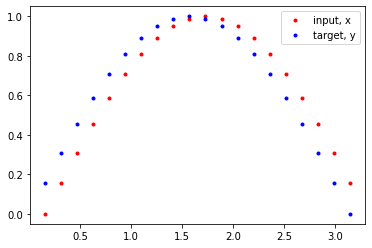

In [5]:
x = data[:-1]
y = data[1:]

# display the data
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

In [6]:
print(time_steps)

print(time_steps.shape)

[0.         0.15707963 0.31415927 0.4712389  0.62831853 0.78539816
 0.9424778  1.09955743 1.25663706 1.41371669 1.57079633 1.72787596
 1.88495559 2.04203522 2.19911486 2.35619449 2.51327412 2.67035376
 2.82743339 2.98451302 3.14159265]
(21,)


## Define RNN

Architecture: RNN followed by a fully connected neural network

input_size: size of input <br>
output_size: Size of output of the entire model, that is, output from the last fully connected layer <br>
hidden_dim: Size of the output from RNN part of the model <br>
n_layers: Number of layers in RNN part of the model <br>

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size = hidden_dim, num_layers=n_layers, 
                          batch_first= True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        """
        x is input of dimension (batch_size, sequence length, feature/input size)
        hidden is initial hidden state
        """
        batch_size = x.size(0)
        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)
        output = self.fc(r_out)
        return output, hidden

### Check / Test the Output and Input Dimension Correctness

In [8]:
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate test data
time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data = data.reshape(-1,1)
data.shape

(20, 1)

In [9]:
test_data = torch.Tensor(data).unsqueeze(0)
test_data.shape

torch.Size([1, 20, 1])

### Test Callable Objects in Python

In [10]:
class TestClass:
    def __init__(self, a):
        self.a = a
        
    def doSomething(self, b):
        print("Executing doSomething with parameter: ", b)
        
    def __call__(self, b):
        self.doSomething(b)

t = TestClass(5)

In [11]:
t(6)

Executing doSomething with parameter:  6


## Run the Neural Network

In [12]:
# test the rnn
test_rnn

RNN(
  (rnn): RNN(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [13]:
test_out, test_hidden = test_rnn(test_data, None)
print("Model Output size: ", test_out.size())
print("RNN hidden size: ", test_hidden.size())

Model Output size:  torch.Size([20, 1])
RNN hidden size:  torch.Size([2, 1, 10])


## Train the RNN

In [14]:
#Hyper-paramters
input_size = 1
output_size = 1
hidden_dim = 5
n_layers = 2

#instantiate RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 5, num_layers=2, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)


In [15]:
# Loss function
criterion=nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.1)

In [16]:
def train(rnn, n_steps, print_every, show_graph):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
#         loss.backward(retain_graph = True)
        optimizer.step()

        # display loss and predictions

        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            if show_graph:
                plt.plot(time_steps[1:], x, 'r.') # input
                plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
                plt.show()
    
    return rnn, loss.item()      
        
        
# def define_training_data(step):
#     time_steps = np.linspace(step*np.pi, (step + 1) *np.pi, seq_length+1)
#     data = np.sin(time_steps)
#     data = data.reshape(-1, 1)
#     x = data[:-1]
#     y = data[1:]
    
#     x_tensor = torch.Tensor(x).unsqueeze(0)
#     y_tensor = torch.Tensor(y)
    
#     return x,y,x_tensor, y_tensor, time_steps

hidden dimension 1
Loss:  0.8691529631614685


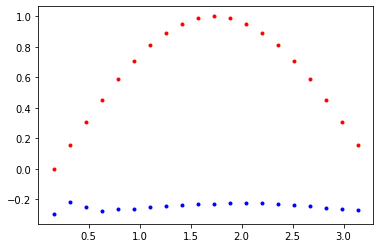

Loss:  0.05950691178441048


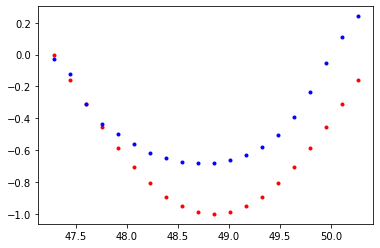

Loss:  0.0029762100894004107


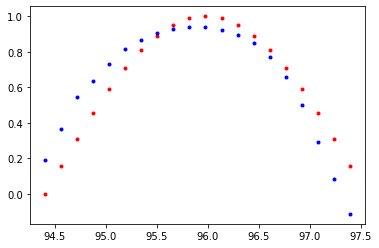

Loss:  0.0032019075006246567


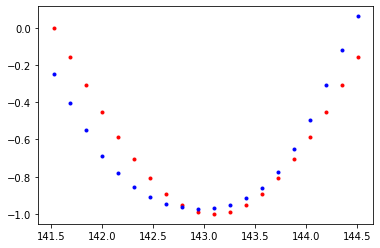

Loss:  0.0012169118272140622


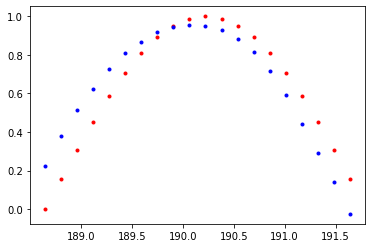

Loss:  0.0006959761376492679


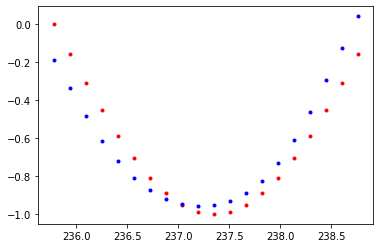

Loss:  0.0003681777452584356


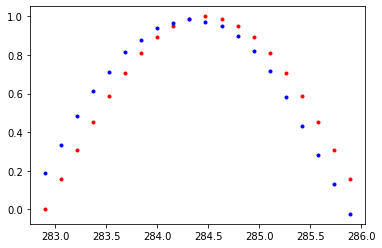

Loss:  0.0002371001901337877


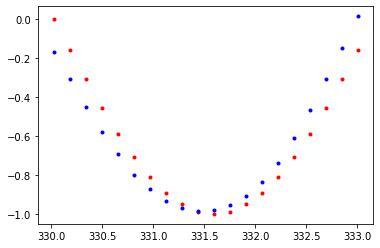

Loss:  0.00017156434478238225


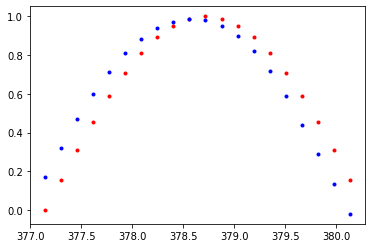

Loss:  9.671963925939053e-05


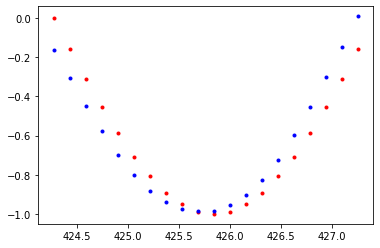

Loss:  0.0003418721607886255


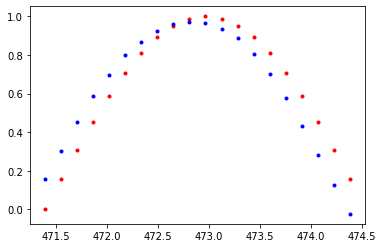

Loss:  0.00759457191452384


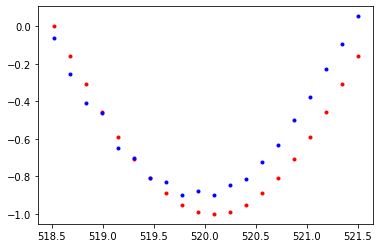

Loss:  0.0002753188891801983


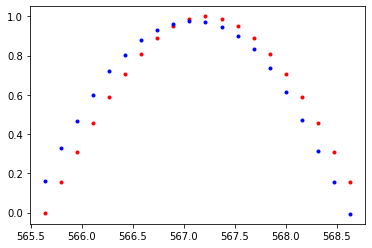

Loss:  0.00017404202662874013


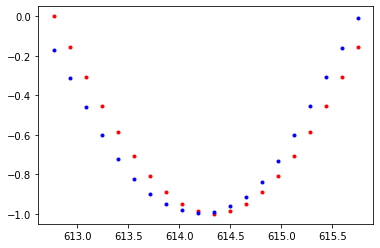

Loss:  0.00013788731303066015


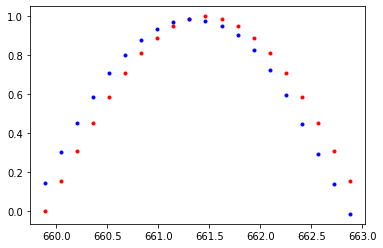

Loss:  5.8863111917162314e-05


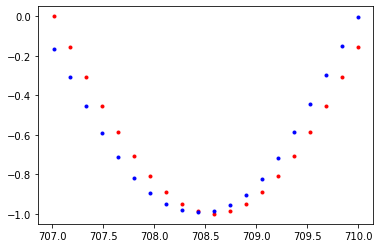

Loss:  0.0006462428718805313


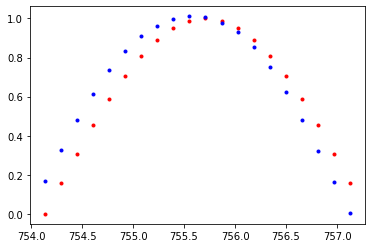

Loss:  0.00496256398037076


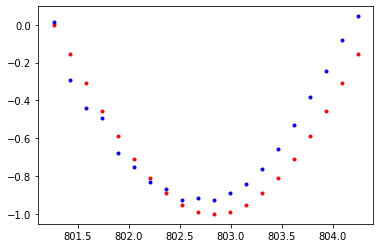

Loss:  0.0003990939003415406


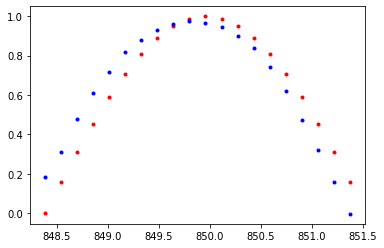

Loss:  0.00011899229866685346


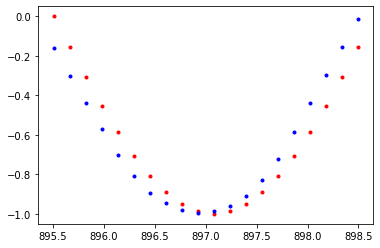

Loss:  0.00017624087922740728


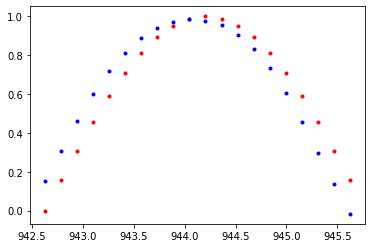

Loss:  5.284828148433007e-05


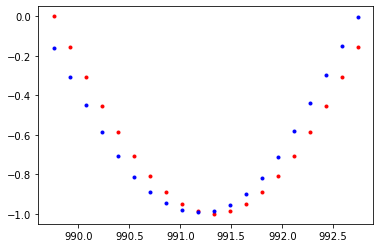

Loss:  0.0001301005540881306


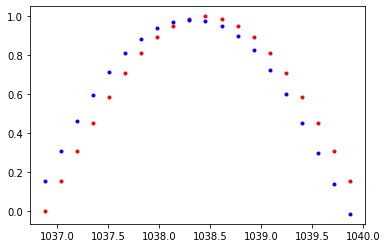

Loss:  3.506825305521488e-05


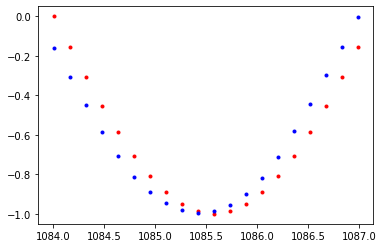

Loss:  0.0001033716689562425


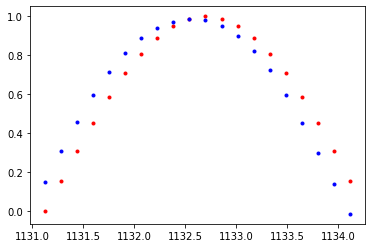

Loss:  3.581398414098658e-05


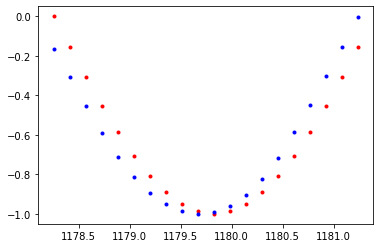

Loss:  0.001164672547020018


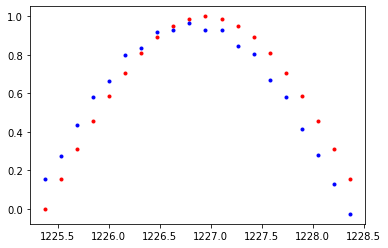

Loss:  0.021639229729771614


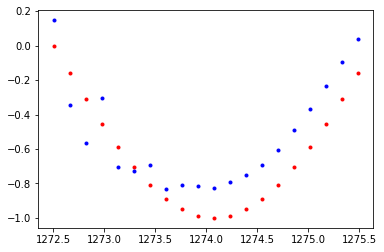

Loss:  0.004224254284054041


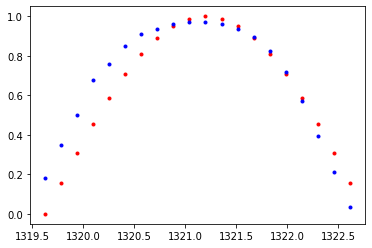

Loss:  0.0007307474152185023


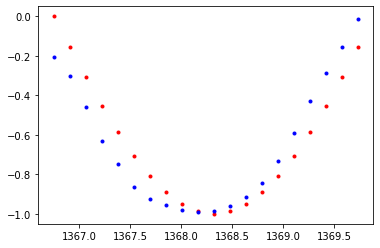

Loss:  0.0005657114088535309


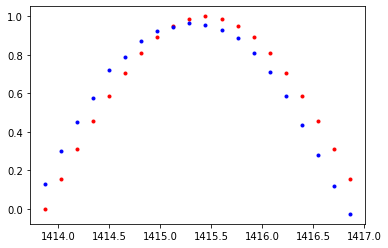

Loss:  0.0004532197490334511


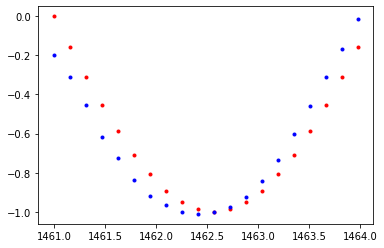

Loss:  0.00027493483503349125


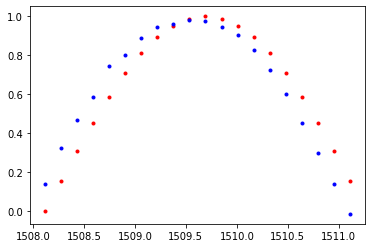

Loss:  0.0004824944189749658


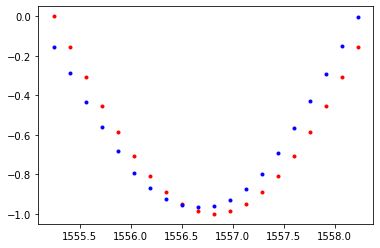

Loss:  0.0006956352153792977


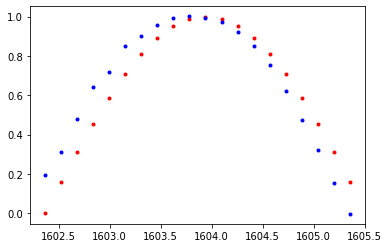

Loss:  0.00022373652609530836


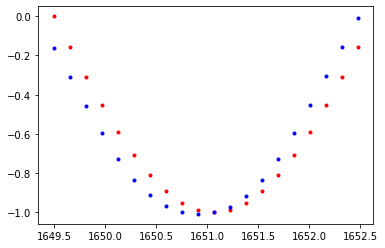

Loss:  0.00025502702919766307


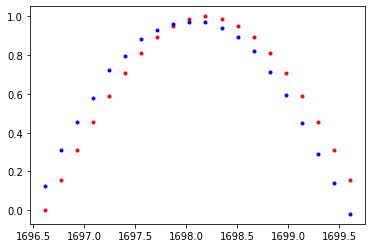

Loss:  0.00035411445423960686


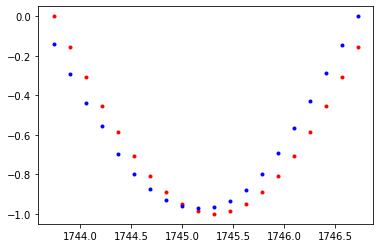

Loss:  0.0012295977212488651


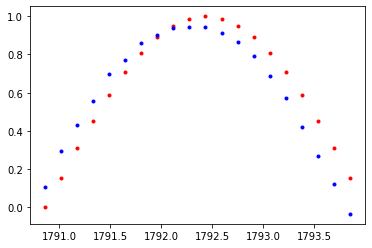

Loss:  0.0010165789863094687


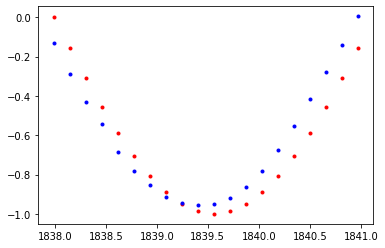

Loss:  0.003169866744428873


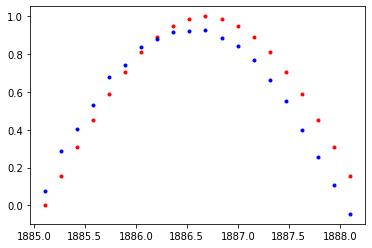

Loss:  0.0013234912184998393


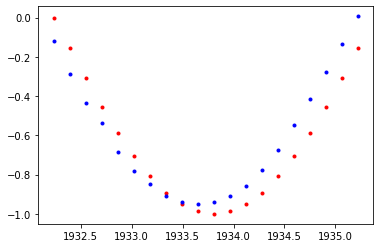

Loss:  0.0021822855342179537


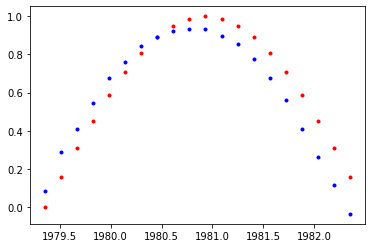

Loss:  0.0006501274183392525


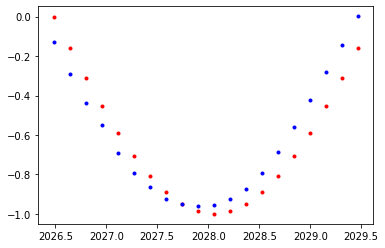

Loss:  0.0008720526820980012


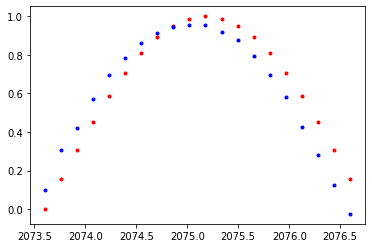

Loss:  9.072438842849806e-05


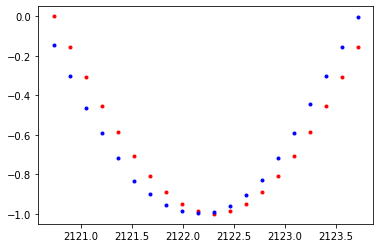

Loss:  0.002605967689305544


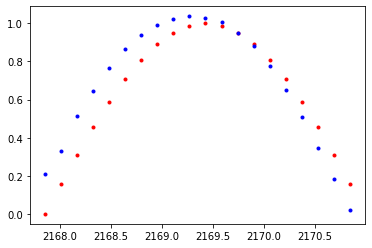

Loss:  0.00041571364272385836


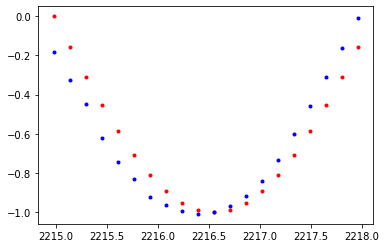

Loss:  0.00026595714734867215


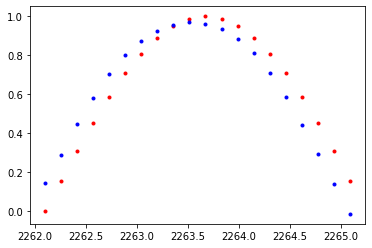

Loss:  0.0003100956091657281


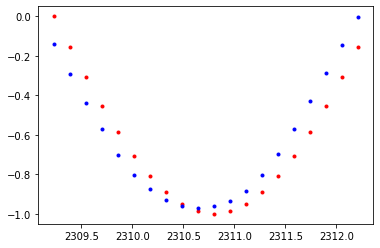

Loss:  0.00011446860298747197


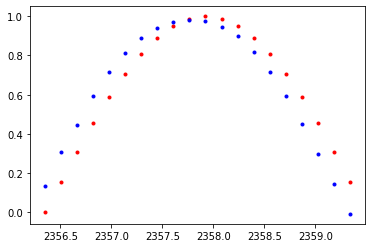

Loss:  7.746979827061296e-05


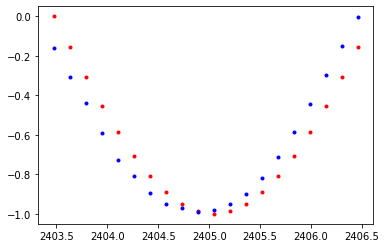

Loss:  0.004320343025028706


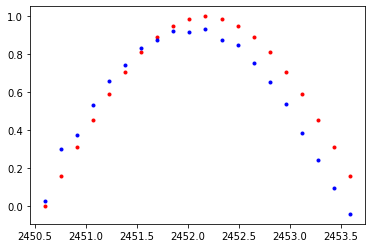

Loss:  0.001596317277289927


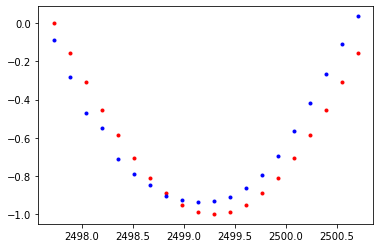

Loss:  0.00023700844030827284


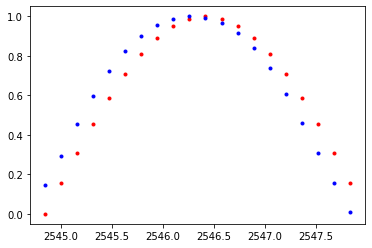

Loss:  0.00054480618564412


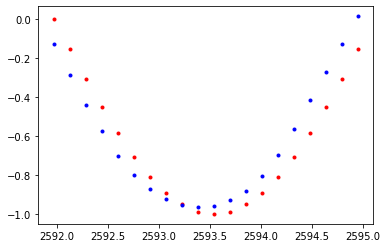

Loss:  0.005624670069664717


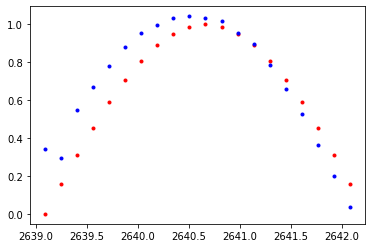

Loss:  0.0008360206848010421


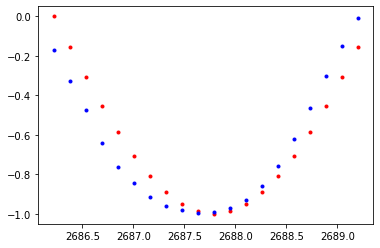

Loss:  0.00016443131607957184


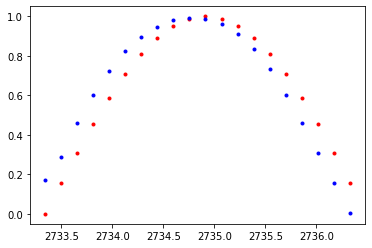

Loss:  0.0006465095211751759


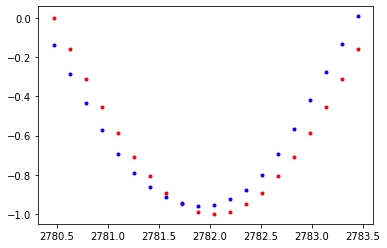

Loss:  0.0001876038732007146


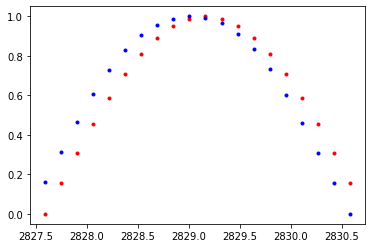

Loss:  0.004693715367466211


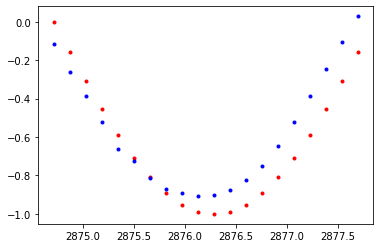

Loss:  0.002700872253626585


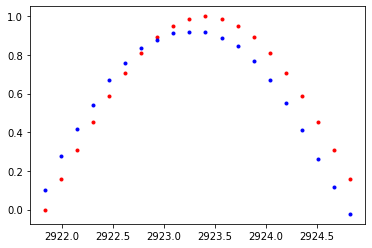

Loss:  0.001367761055007577


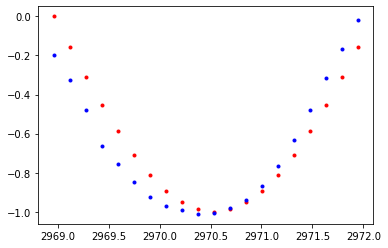

Loss:  0.0007101381779648364


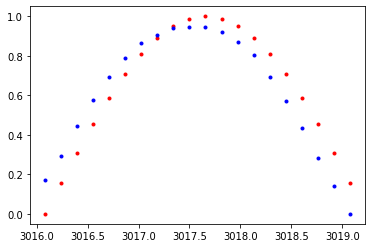

Loss:  0.0004981265519745648


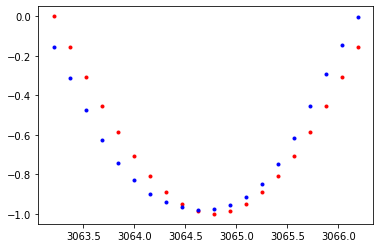

Loss:  0.00014797973562963307


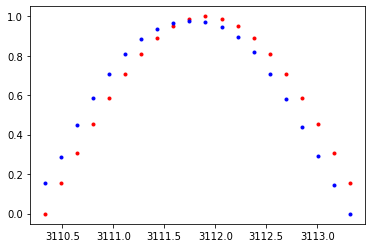

hidden dimension 6
Loss:  0.02526790462434292


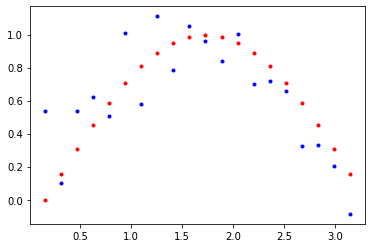

Loss:  0.021876536309719086


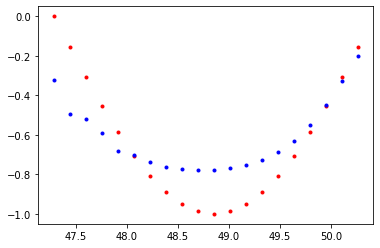

Loss:  0.003647151170298457


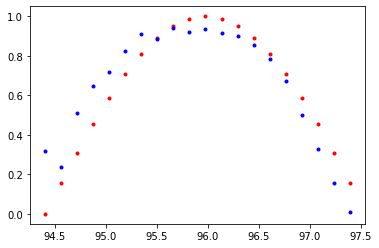

Loss:  0.0011965763987973332


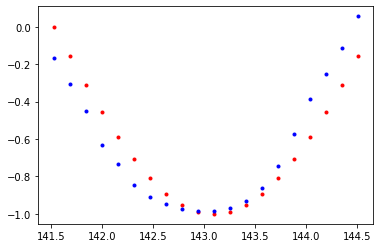

Loss:  0.0005980532732792199


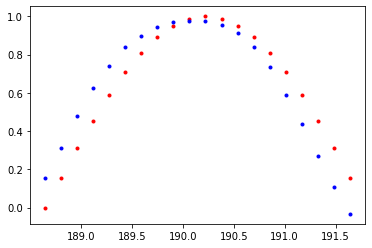

Loss:  0.00021333142649382353


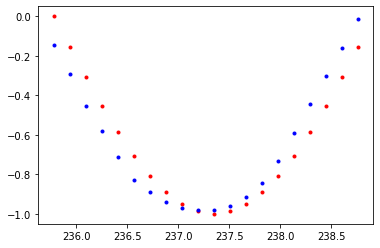

Loss:  0.00024758640211075544


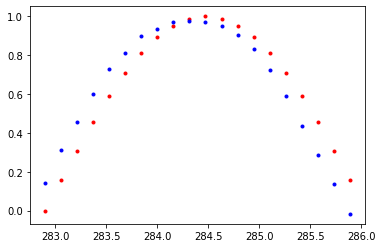

Loss:  0.00011414149776101112


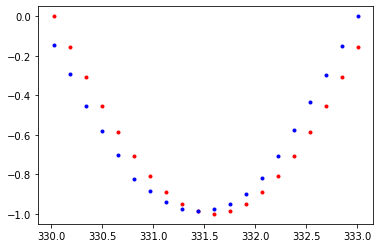

Loss:  0.0009510964155197144


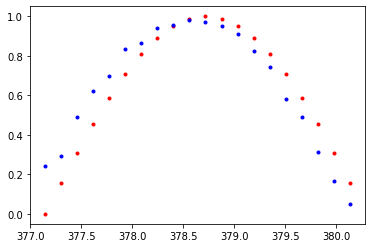

Loss:  0.006365255918353796


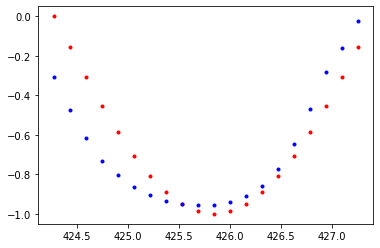

Loss:  0.0008507653255946934


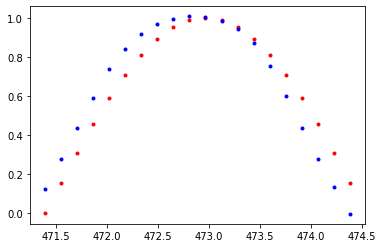

Loss:  0.00031956599559634924


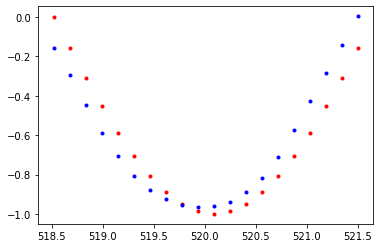

Loss:  0.00013525185931939632


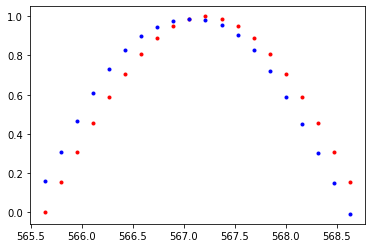

Loss:  8.505165169481188e-05


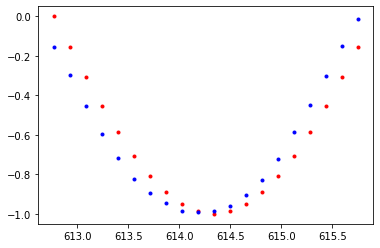

Loss:  0.0031088280957192183


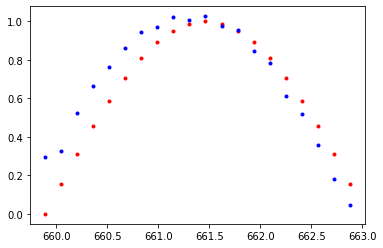

Loss:  0.0019881001207977533


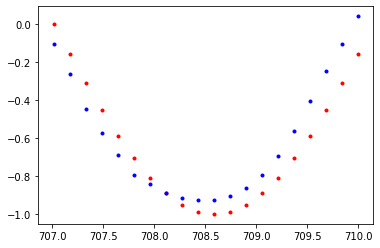

Loss:  0.00034823769237846136


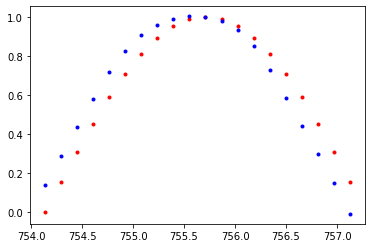

Loss:  0.0001344088086625561


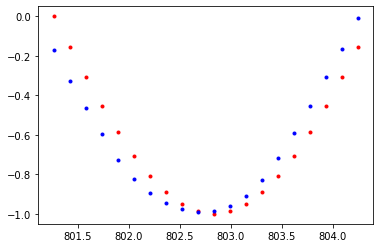

Loss:  4.771218300447799e-05


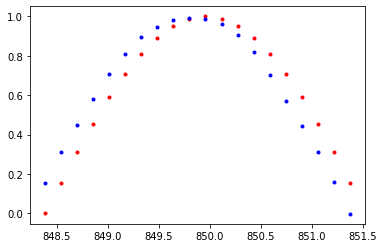

Loss:  3.0295557735371403e-05


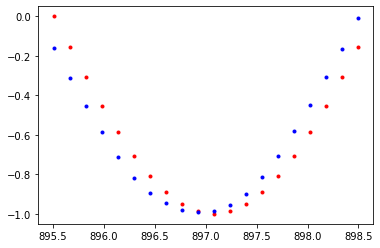

Loss:  3.1117328035179526e-05


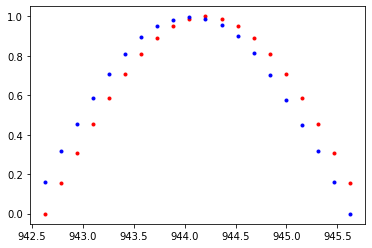

Loss:  2.562835106800776e-05


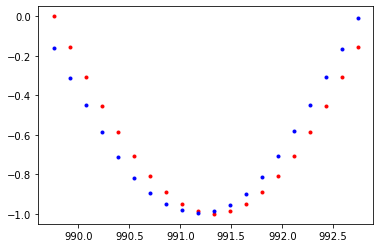

Loss:  2.318700535397511e-05


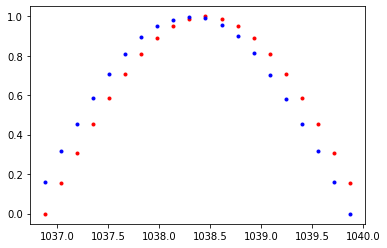

Loss:  2.1037865735706873e-05


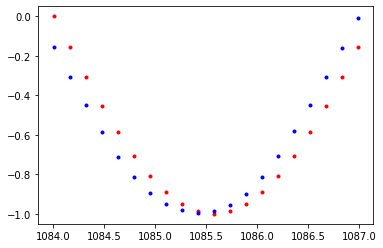

Loss:  1.6795775081845932e-05


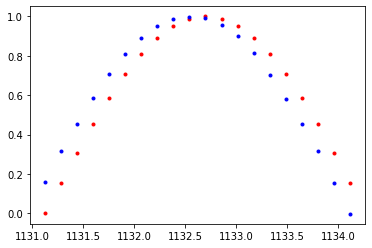

Loss:  2.836893509083893e-05


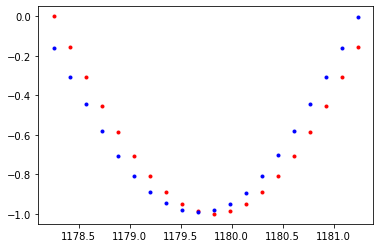

Loss:  0.0003045720513910055


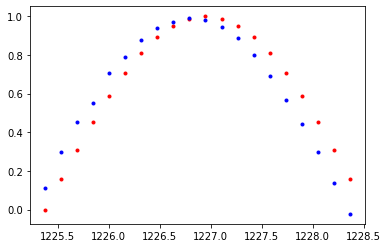

Loss:  0.0006587735842913389


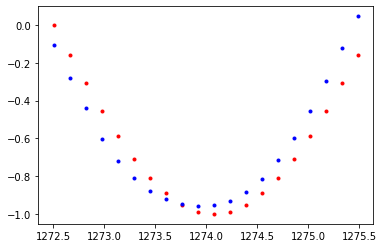

Loss:  0.00031627959106117487


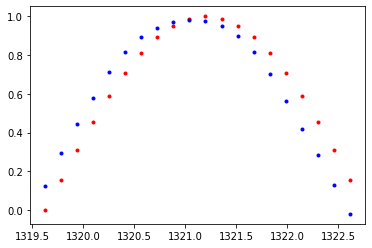

Loss:  8.991610957309604e-05


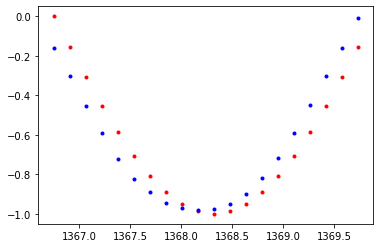

Loss:  7.170886965468526e-05


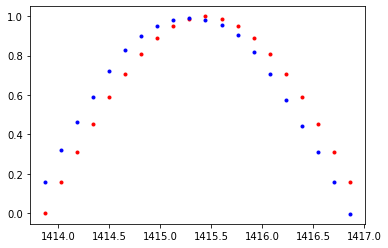

Loss:  7.075387838995084e-05


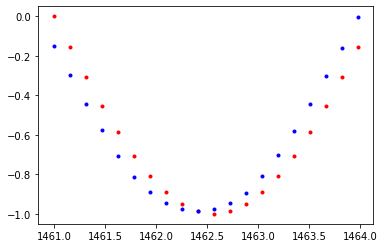

Loss:  0.00048258050810545683


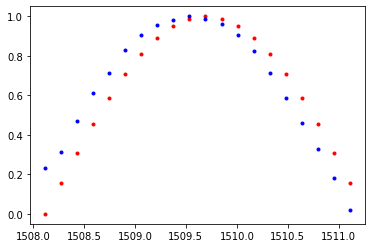

Loss:  0.0014074310893192887


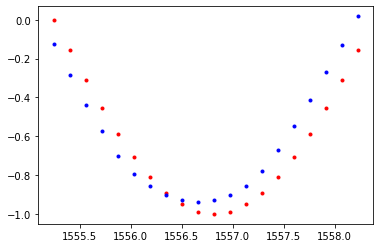

Loss:  0.00029833841836079955


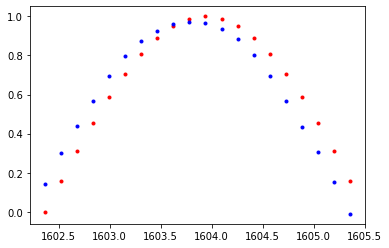

Loss:  0.00015028408961370587


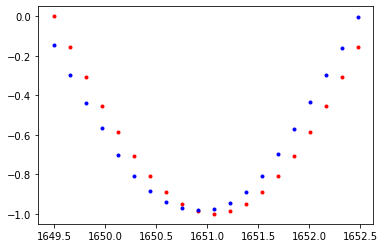

Loss:  3.9083904994186014e-05


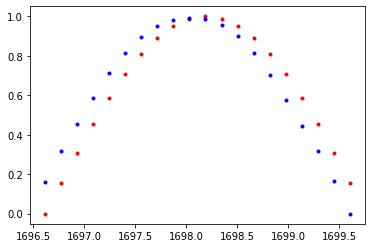

Loss:  5.781488653155975e-05


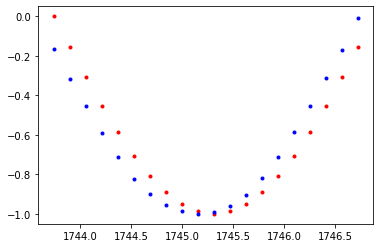

Loss:  3.396125975996256e-05


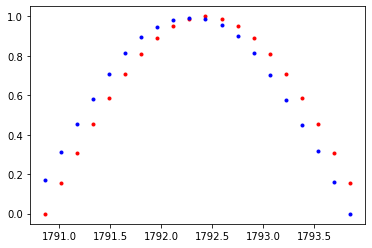

Loss:  0.00017606500477995723


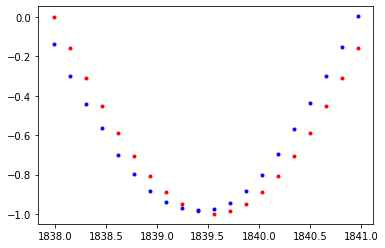

Loss:  0.001919291913509369


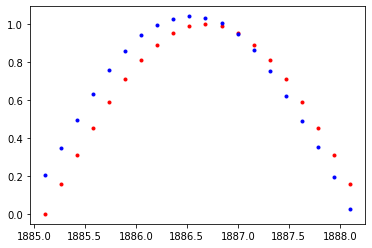

Loss:  0.0017320342594757676


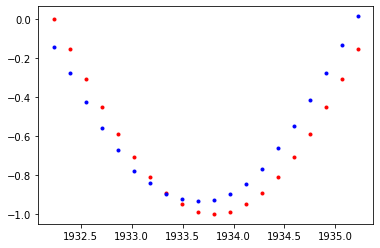

Loss:  0.0012232842855155468


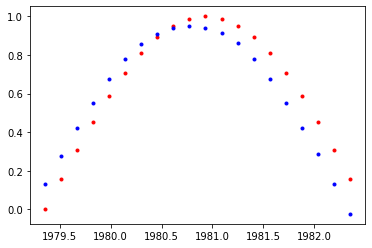

Loss:  0.00042056688107550144


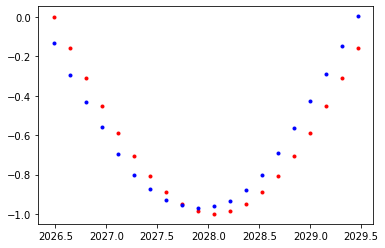

Loss:  4.0965660446090624e-05


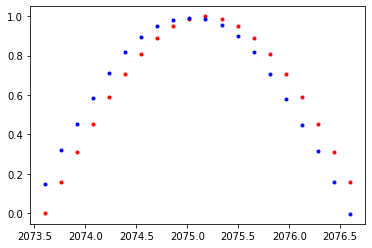

Loss:  0.00032141958945430815


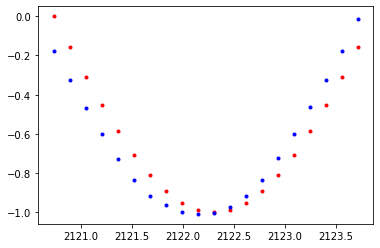

Loss:  0.0002757477341219783


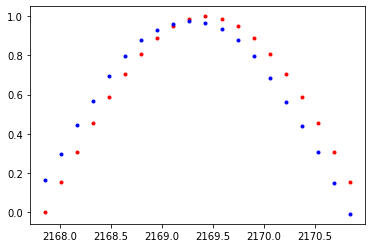

Loss:  0.0005329987034201622


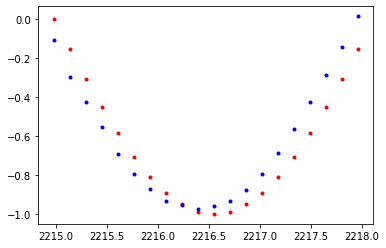

Loss:  0.0024381354451179504


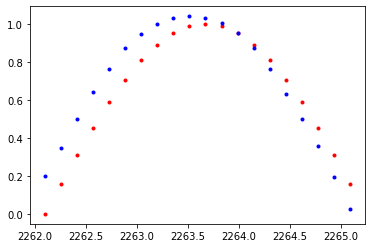

Loss:  0.0004200768889859319


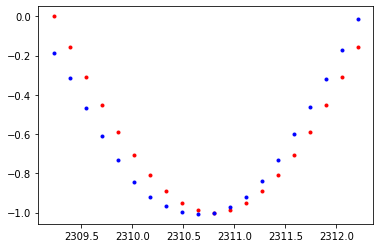

Loss:  7.645782898180187e-05


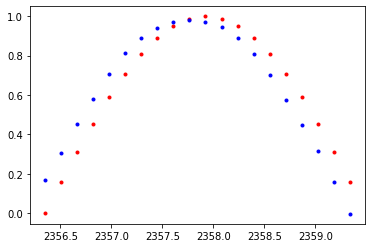

Loss:  0.00019426435756031424


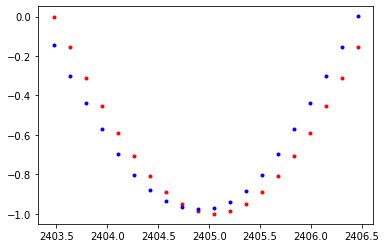

Loss:  0.000154922207002528


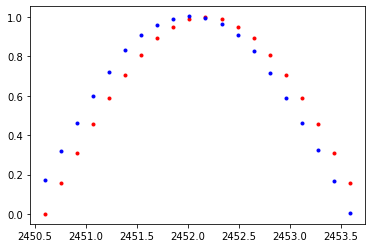

Loss:  9.487676288699731e-05


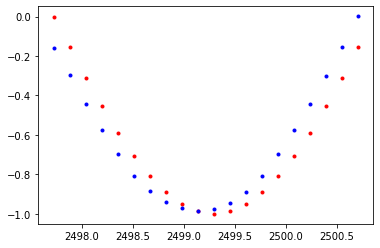

Loss:  3.676040068967268e-05


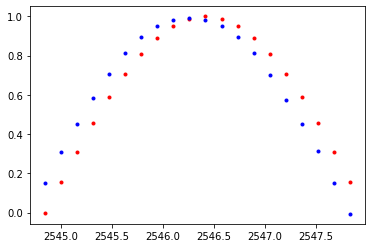

Loss:  0.0005651708925142884


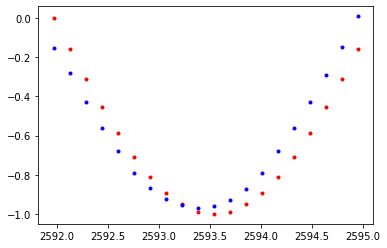

Loss:  0.003458490828052163


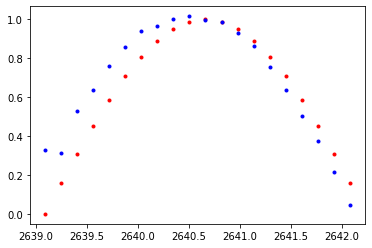

Loss:  0.0008282337221316993


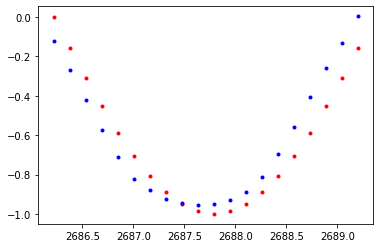

Loss:  0.00028849393129348755


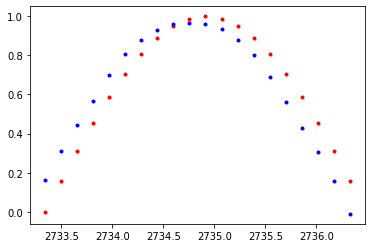

Loss:  0.00027734661125577986


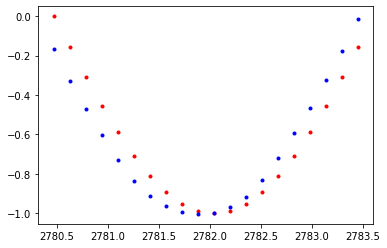

Loss:  9.350082837045193e-05


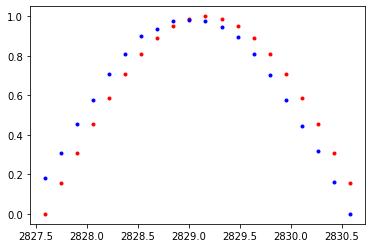

Loss:  0.00011562806321308017


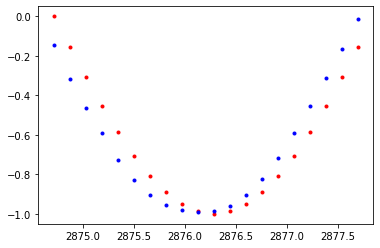

Loss:  0.0017085860017687082


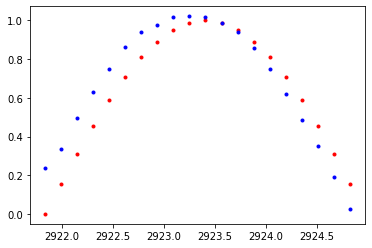

Loss:  0.0001245401072083041


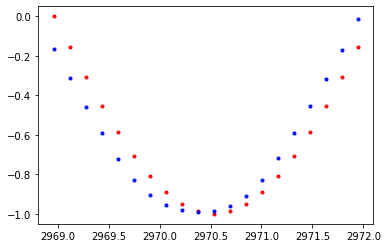

Loss:  0.00016272290667984635


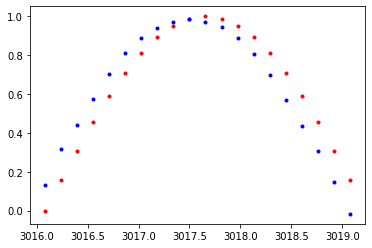

Loss:  0.003214281052350998


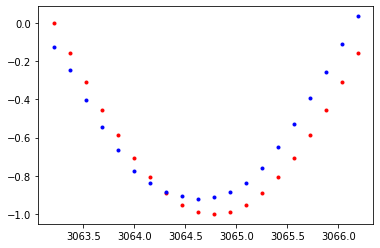

Loss:  0.0014643532922491431


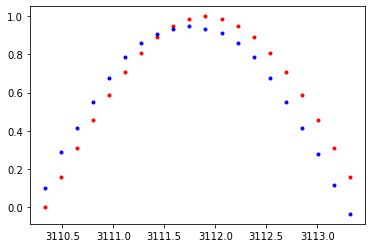

hidden dimension 11
Loss:  0.027039723470807076


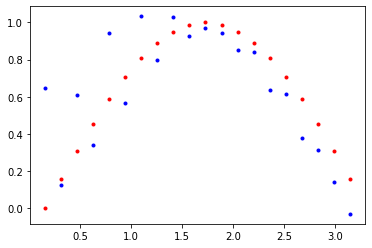

Loss:  0.04976816847920418


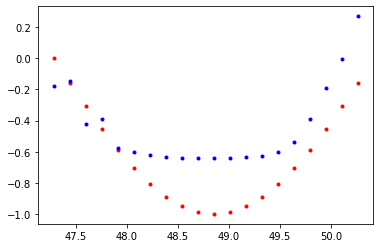

Loss:  0.01575678400695324


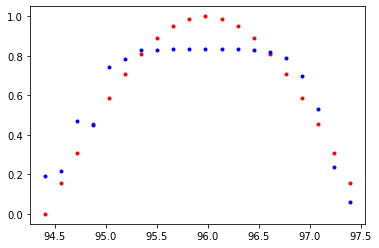

Loss:  0.13852888345718384


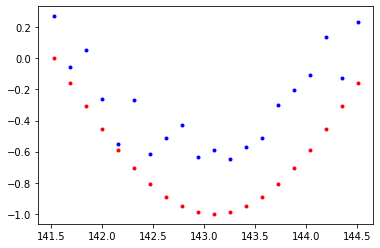

Loss:  0.09721643477678299


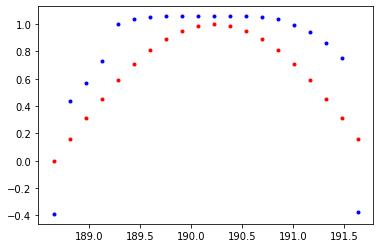

Loss:  0.2435012310743332


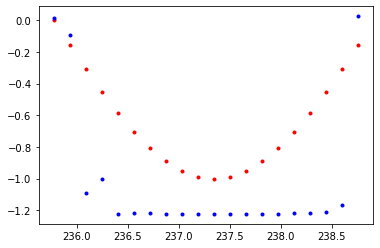

Loss:  0.06922128796577454


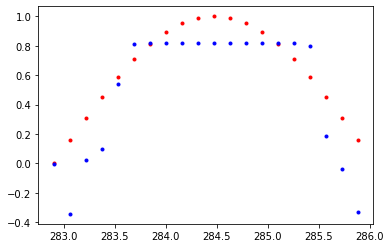

Loss:  0.07997065037488937


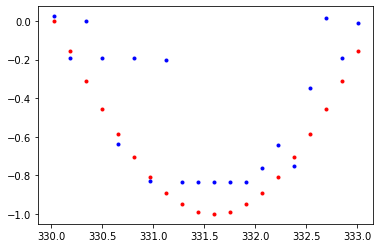

Loss:  0.055994365364313126


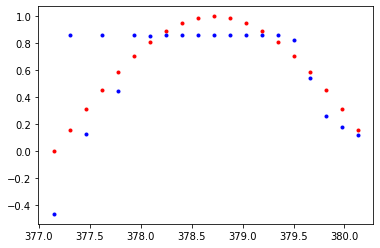

Loss:  0.13809502124786377


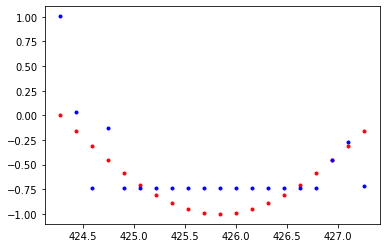

Loss:  0.08264400064945221


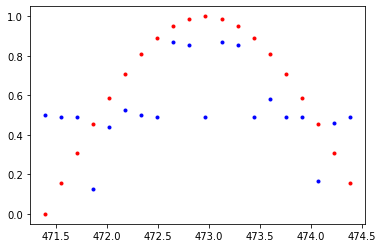

Loss:  0.05675730109214783


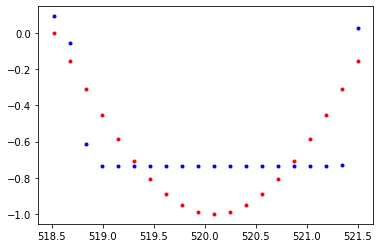

Loss:  0.1362815797328949


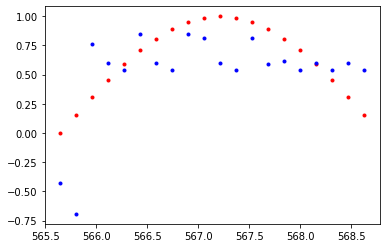

Loss:  0.02837253548204899


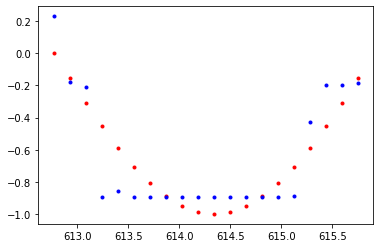

Loss:  0.0670676901936531


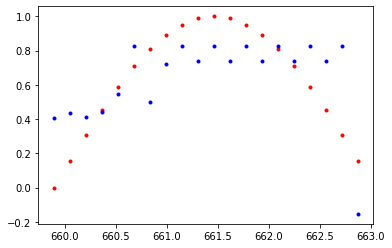

Loss:  0.03551042824983597


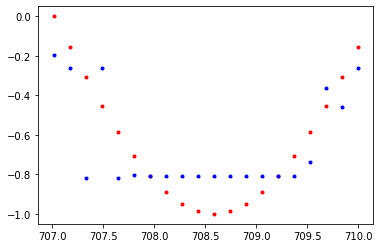

Loss:  0.05712835118174553


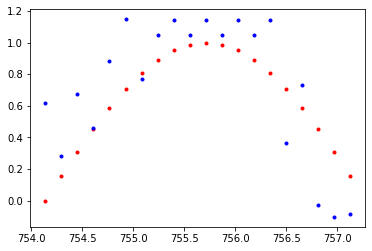

Loss:  0.03948395699262619


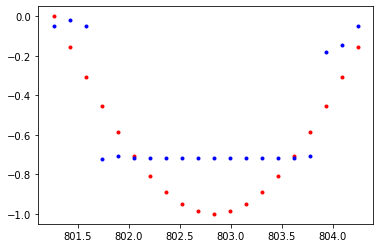

Loss:  0.04619810730218887


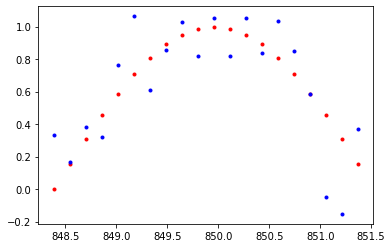

Loss:  0.04381462559103966


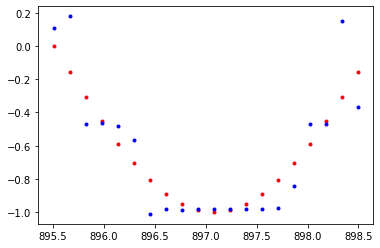

Loss:  0.0470171794295311


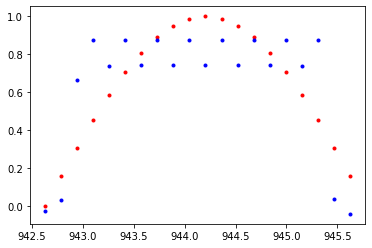

Loss:  0.03572850301861763


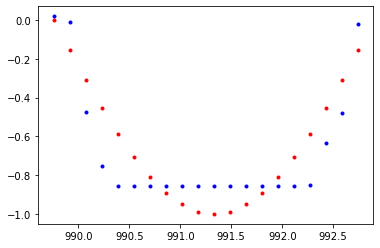

Loss:  0.05524125695228577


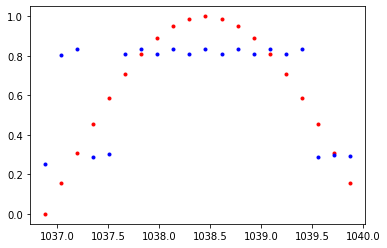

Loss:  0.029974495992064476


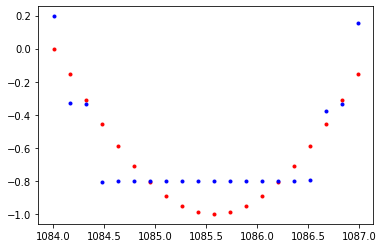

Loss:  0.037981946021318436


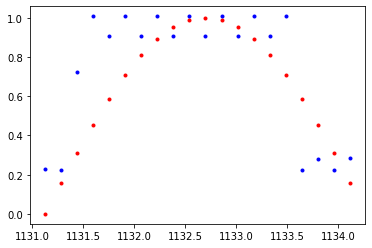

Loss:  0.030542561784386635


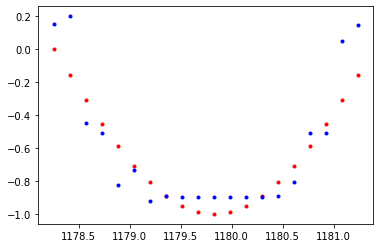

Loss:  0.04440794885158539


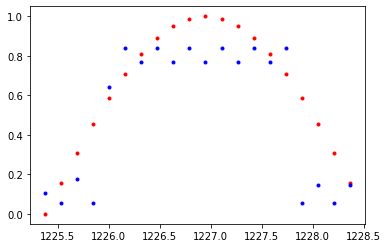

Loss:  0.02561924234032631


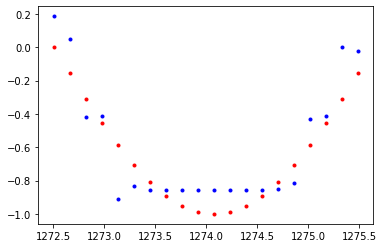

Loss:  0.022210054099559784


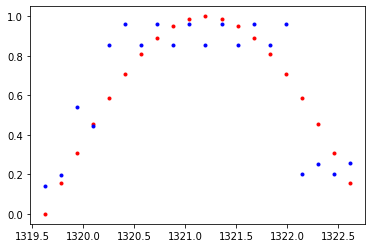

Loss:  0.018671834841370583


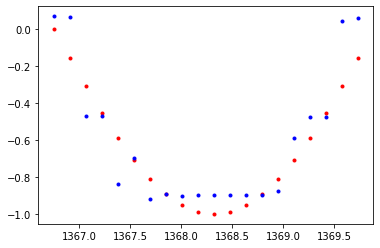

Loss:  0.025817792862653732


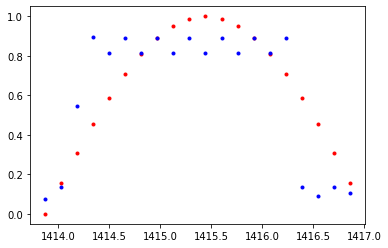

Loss:  0.03568384051322937


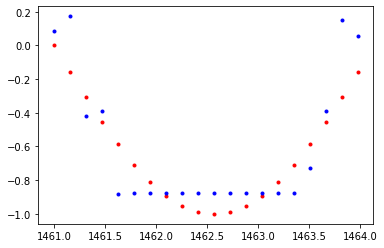

Loss:  0.06992834806442261


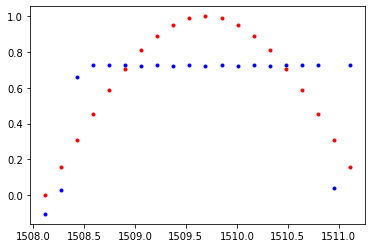

Loss:  0.014491160400211811


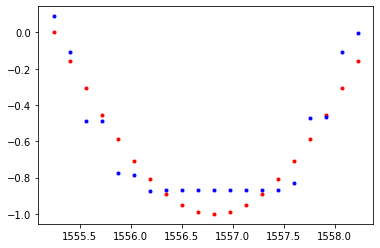

Loss:  0.06572689116001129


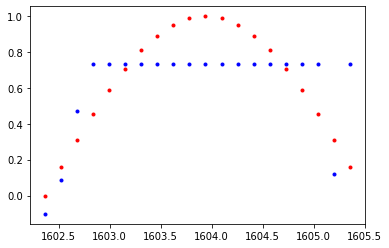

Loss:  0.009626021608710289


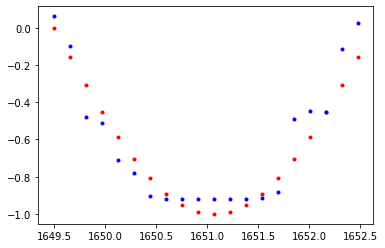

Loss:  0.06571584939956665


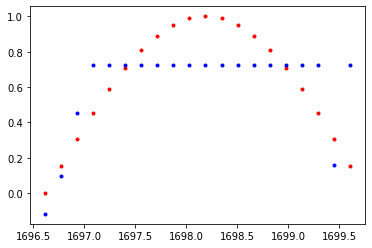

Loss:  0.009115842171013355


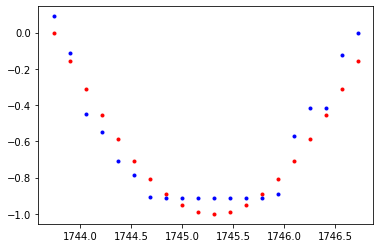

Loss:  0.06586816161870956


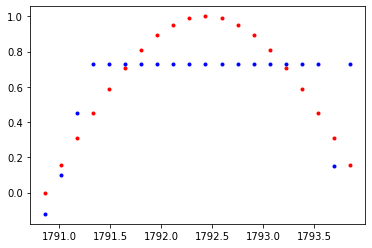

Loss:  0.009067879989743233


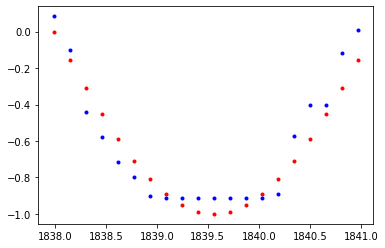

Loss:  0.06574264168739319


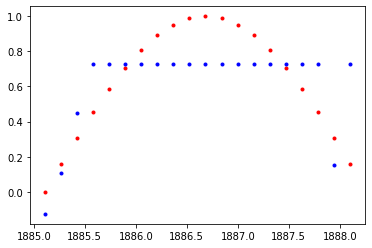

Loss:  0.008657252416014671


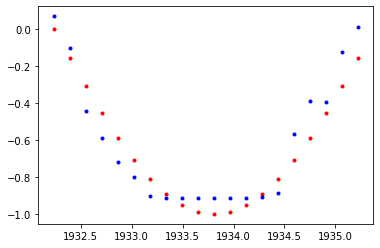

Loss:  0.0653495341539383


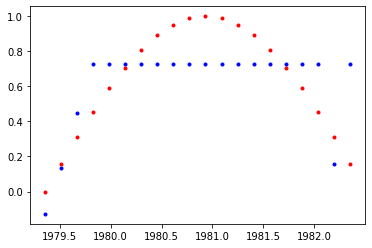

Loss:  0.008239181712269783


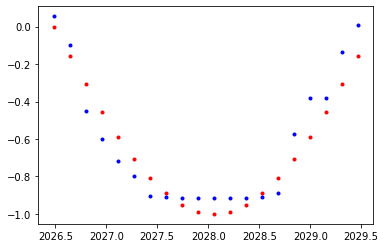

Loss:  0.06472974270582199


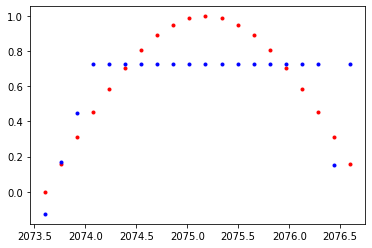

Loss:  0.0077637480571866035


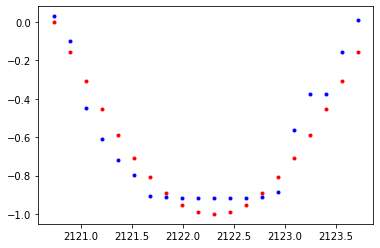

Loss:  0.06381402909755707


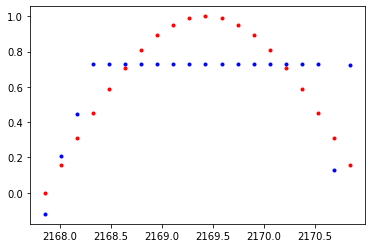

Loss:  0.010474272072315216


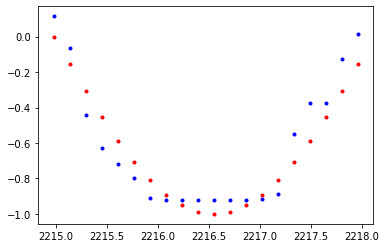

Loss:  0.06680037081241608


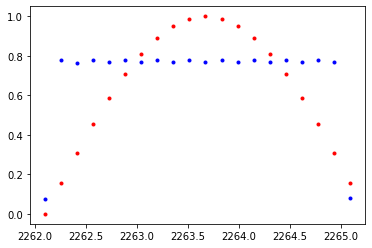

Loss:  0.06341169029474258


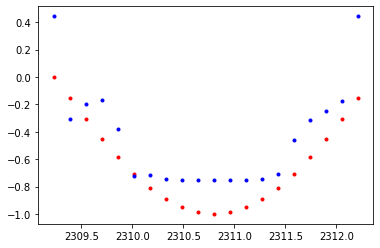

Loss:  0.10347791016101837


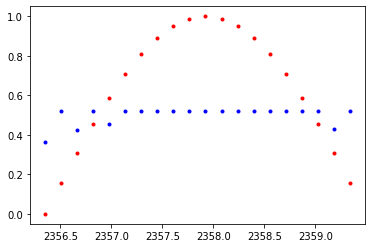

Loss:  0.1707354038953781


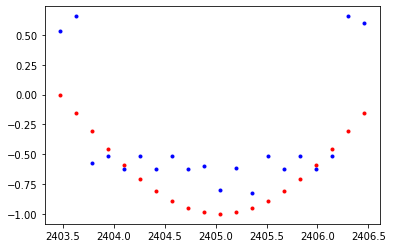

Loss:  0.14619019627571106


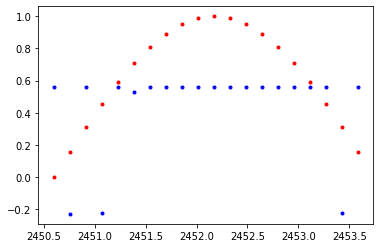

Loss:  0.1084546148777008


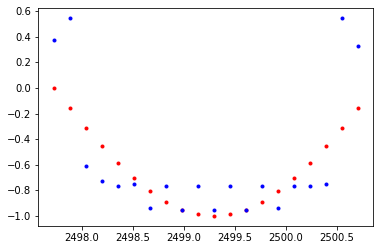

Loss:  0.09554789215326309


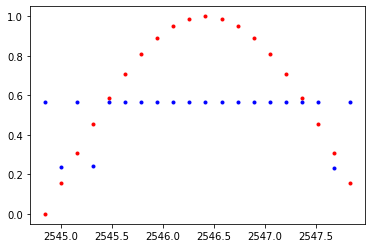

Loss:  0.11345988512039185


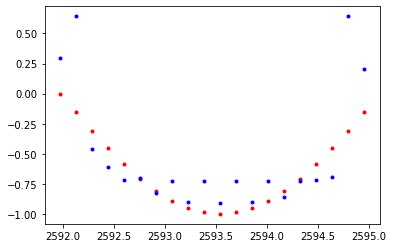

Loss:  0.12861883640289307


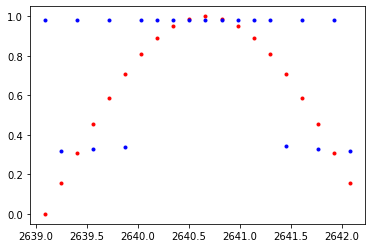

Loss:  0.037019725888967514


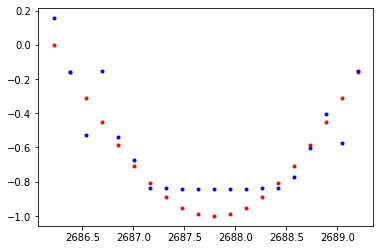

Loss:  0.07917571067810059


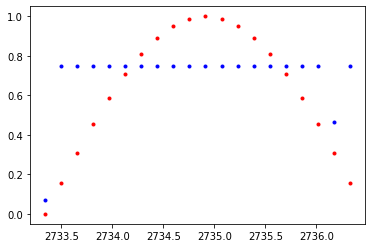

Loss:  0.06783449649810791


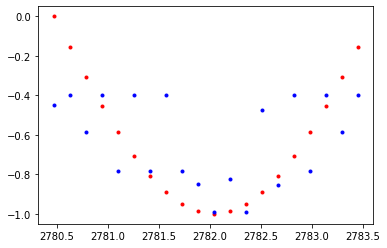

Loss:  0.1294558346271515


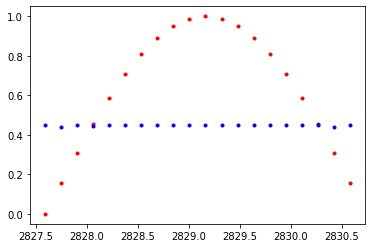

Loss:  0.0742635503411293


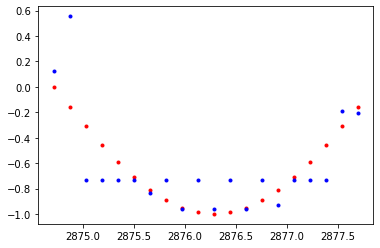

Loss:  0.09530285745859146


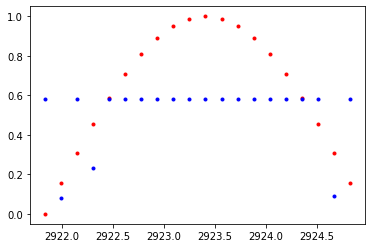

Loss:  0.0820319876074791


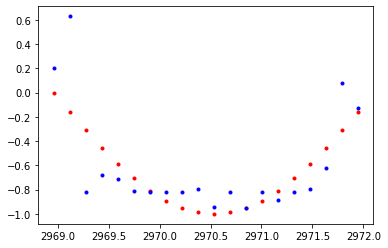

Loss:  0.09629257768392563


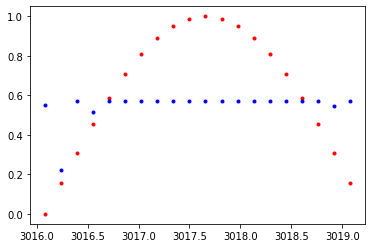

Loss:  0.1433618813753128


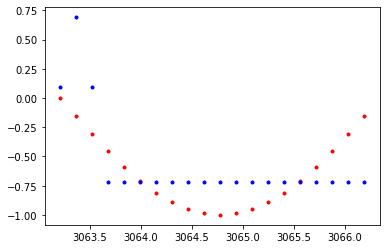

Loss:  0.0890008807182312


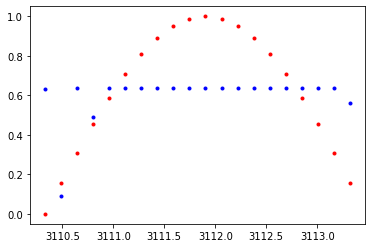

hidden dimension 16
Loss:  0.15125571191310883


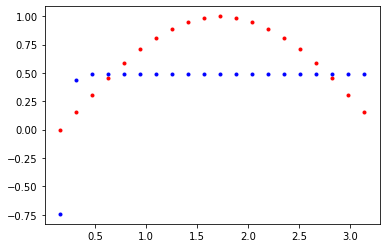

Loss:  0.1191345676779747


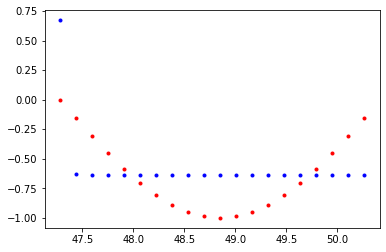

Loss:  0.0912158191204071


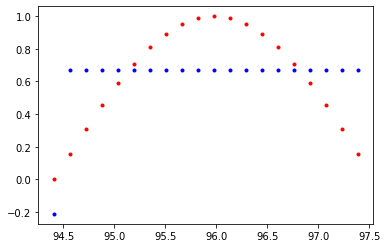

Loss:  0.09518042206764221


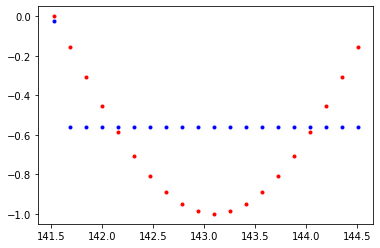

Loss:  0.19832520186901093


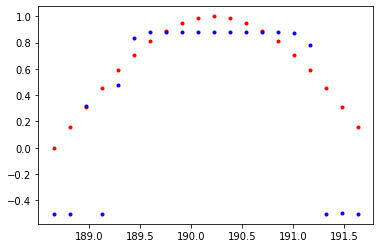

Loss:  0.09360016137361526


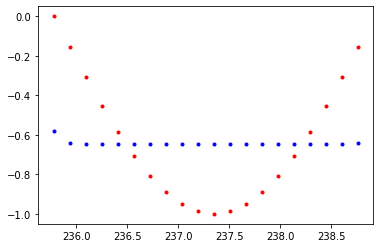

Loss:  0.06381571292877197


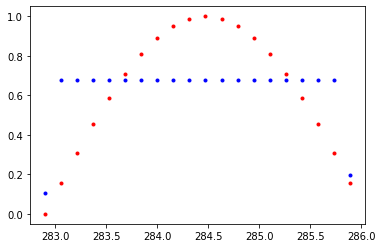

Loss:  0.0821436271071434


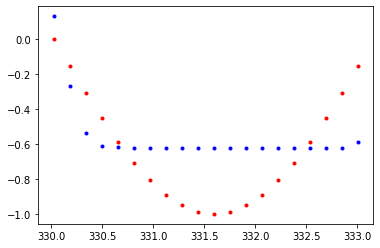

Loss:  0.1081778034567833


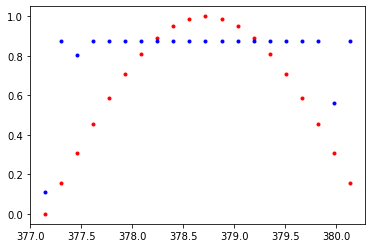

Loss:  0.0791158452630043


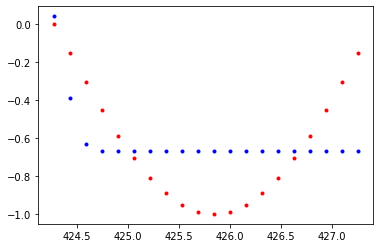

Loss:  0.07547197490930557


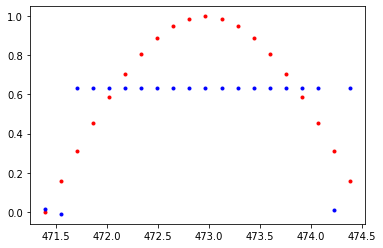

Loss:  0.08080493658781052


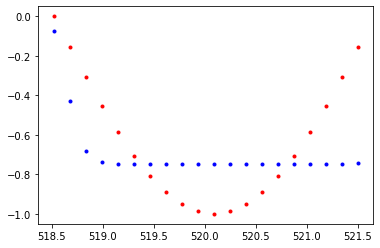

Loss:  0.06462448835372925


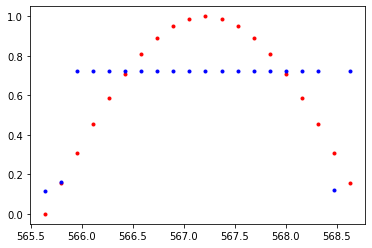

Loss:  0.09383784979581833


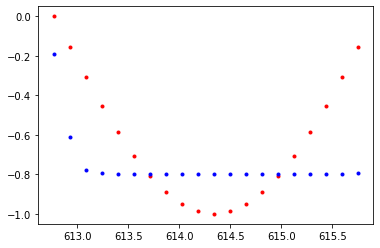

Loss:  0.06348546594381332


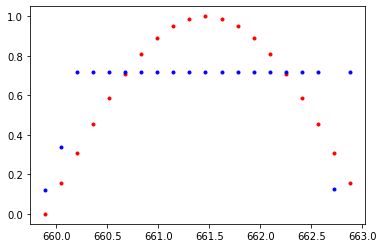

Loss:  0.0754936933517456


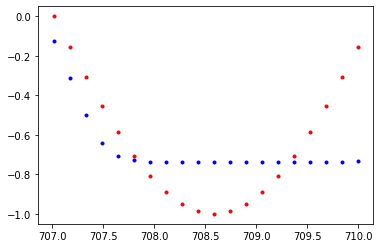

Loss:  0.12699605524539948


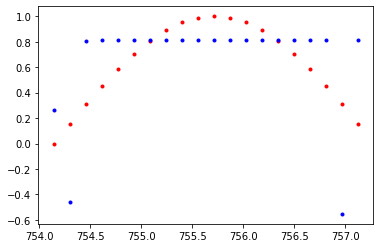

Loss:  0.08818968385457993


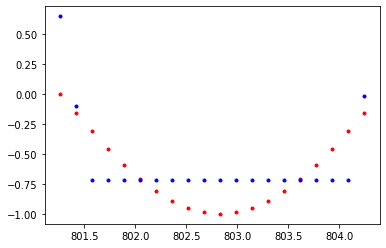

Loss:  0.0768367350101471


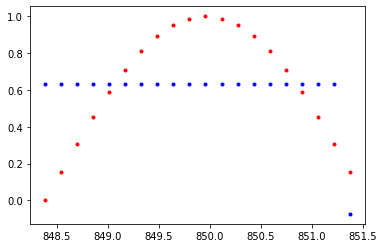

Loss:  0.08563915640115738


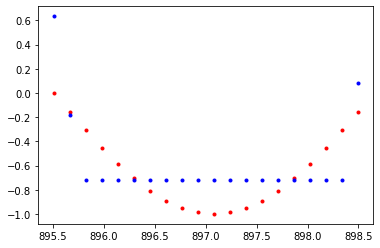

Loss:  0.07736077159643173


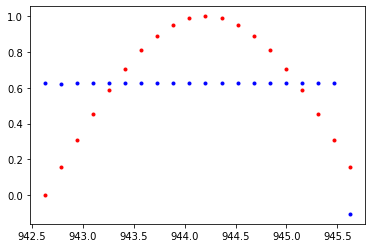

Loss:  0.08508529514074326


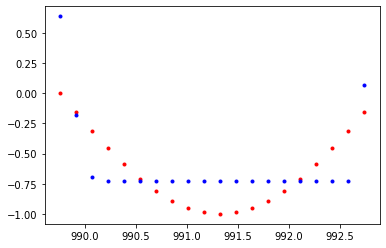

Loss:  0.07542582601308823


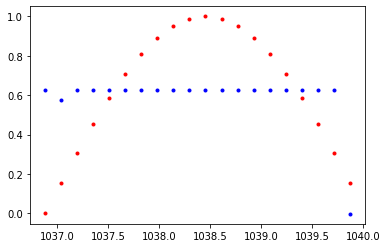

Loss:  0.08236543089151382


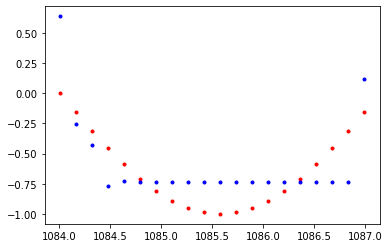

Loss:  0.07702929526567459


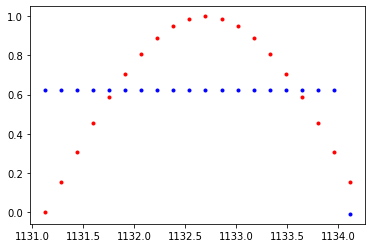

Loss:  0.08226794749498367


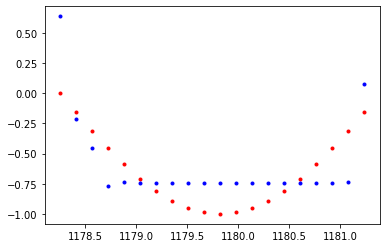

Loss:  0.07719762623310089


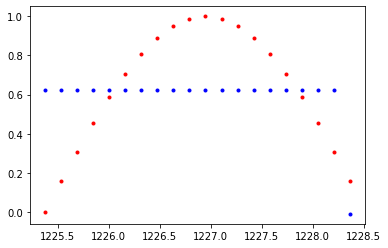

Loss:  0.0822526142001152


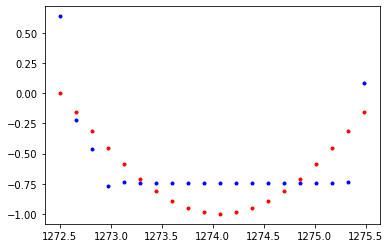

Loss:  0.07716214656829834


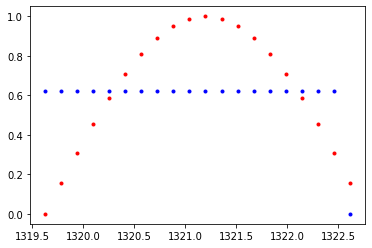

Loss:  0.08223329484462738


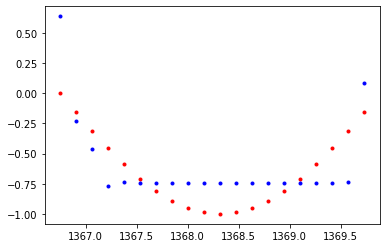

Loss:  0.07714889198541641


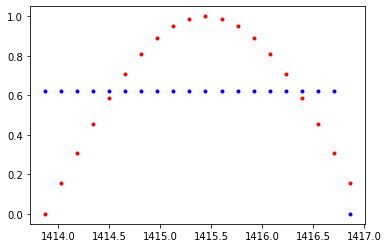

Loss:  0.08217088878154755


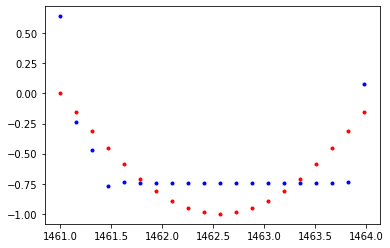

Loss:  0.0771050676703453


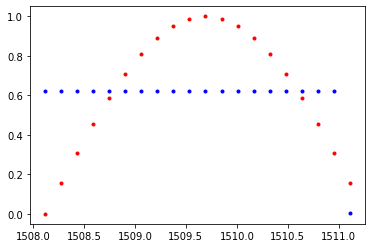

Loss:  0.08199355006217957


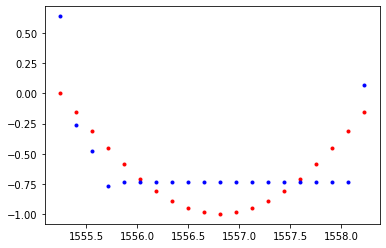

Loss:  0.07698954641819


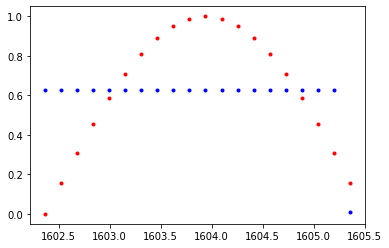

Loss:  0.08184370398521423


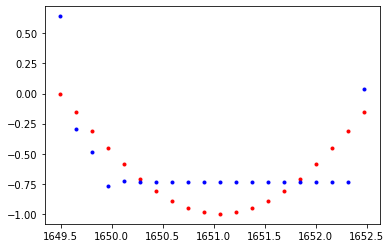

Loss:  0.07687480747699738


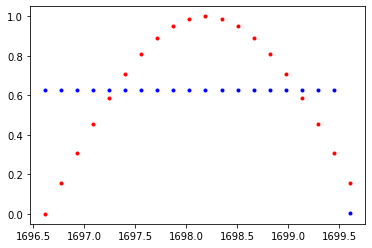

Loss:  0.08181194961071014


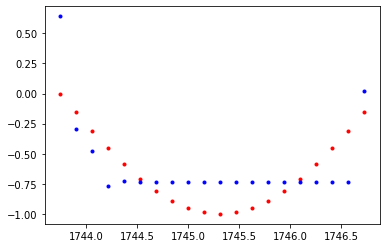

Loss:  0.07684817910194397


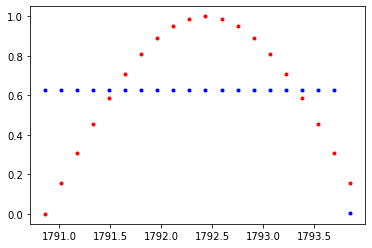

Loss:  0.0817771703004837


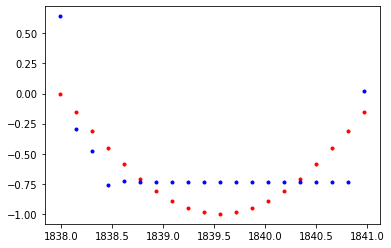

Loss:  0.07684791833162308


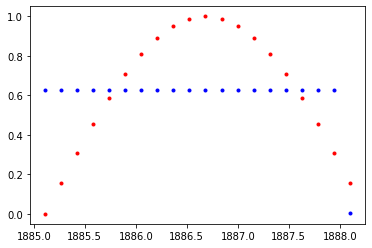

Loss:  0.08174963295459747


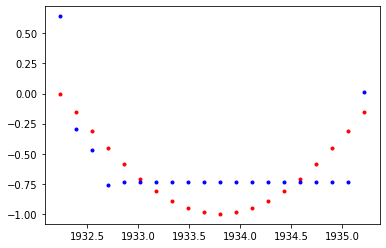

Loss:  0.07684707641601562


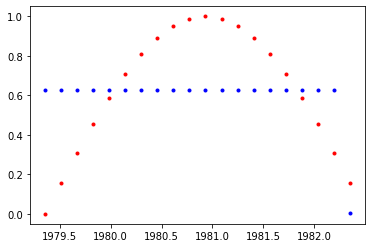

Loss:  0.0817296952009201


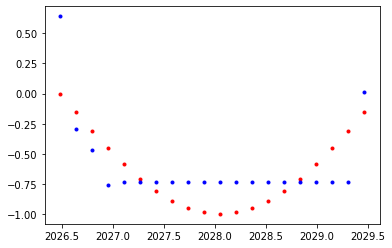

Loss:  0.07684541493654251


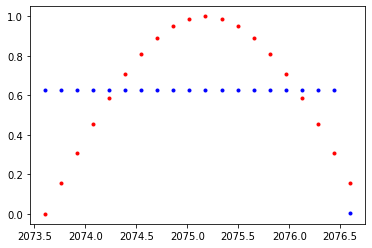

Loss:  0.08171463012695312


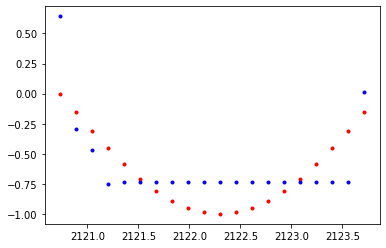

Loss:  0.07684313505887985


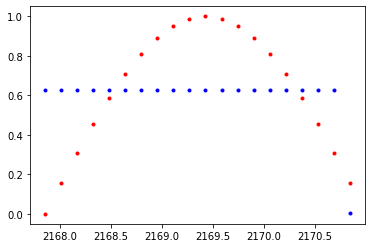

Loss:  0.08170254528522491


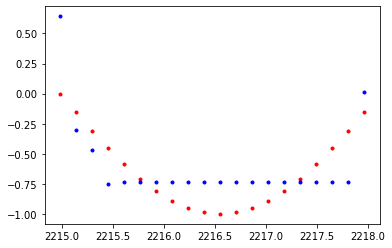

Loss:  0.07684032618999481


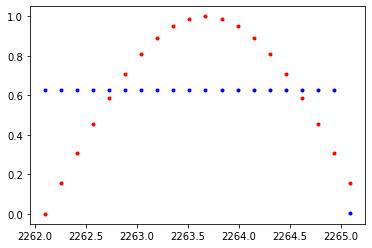

Loss:  0.0816919207572937


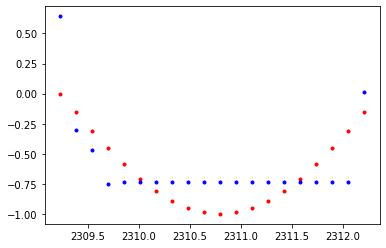

Loss:  0.07683630287647247


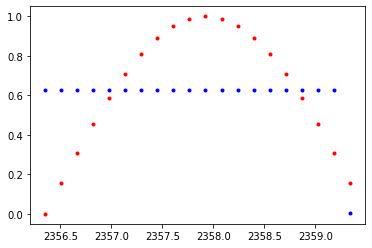

Loss:  0.08168064802885056


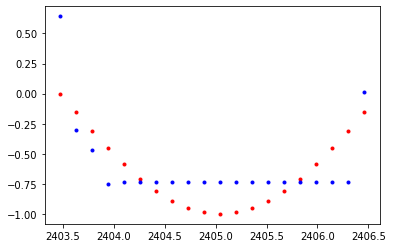

Loss:  0.07682909816503525


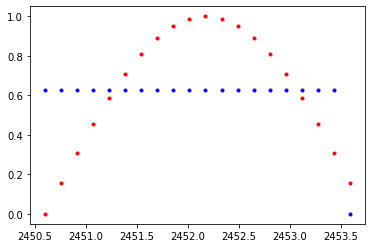

Loss:  0.08166338503360748


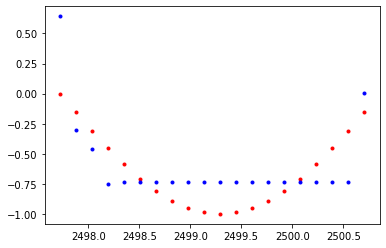

Loss:  0.07680658251047134


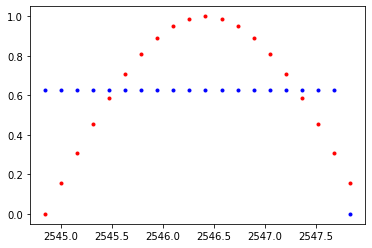

Loss:  0.0815928503870964


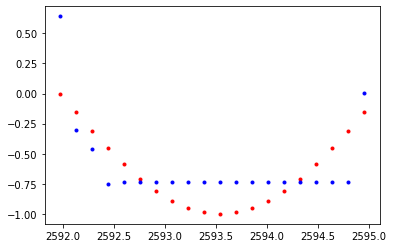

Loss:  0.07583648711442947


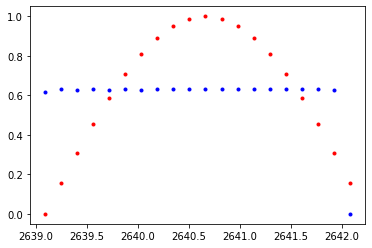

Loss:  0.07818716764450073


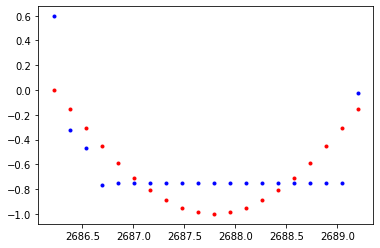

Loss:  0.07321856915950775


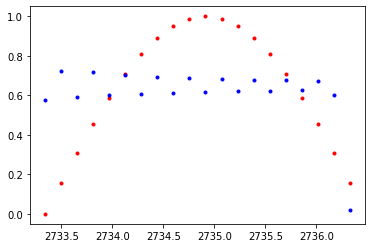

Loss:  0.10351245850324631


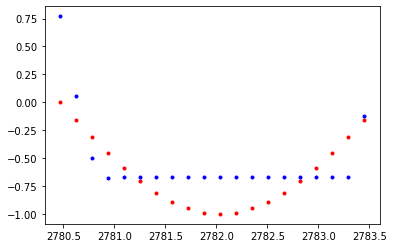

Loss:  0.05914510414004326


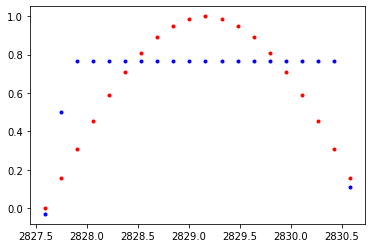

Loss:  0.053566042333841324


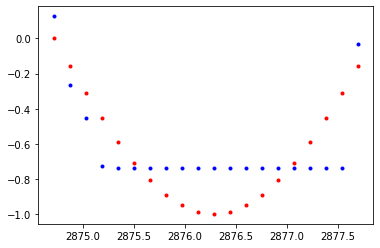

Loss:  0.06733019649982452


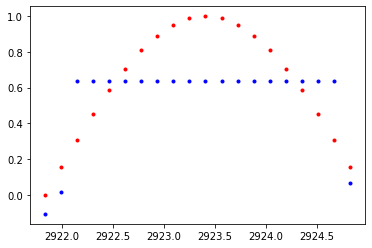

Loss:  0.05649840086698532


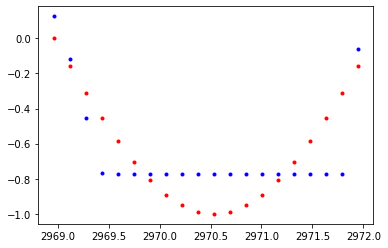

Loss:  0.0762442946434021


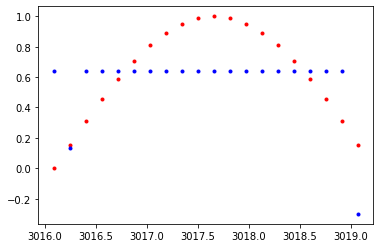

Loss:  0.05210622400045395


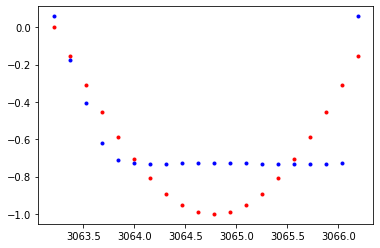

Loss:  0.05883052572607994


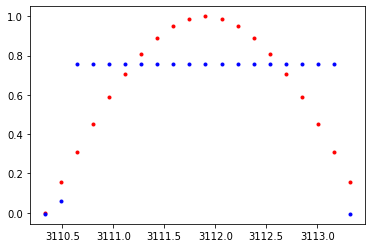

hidden dimension 21
Loss:  0.06040847674012184


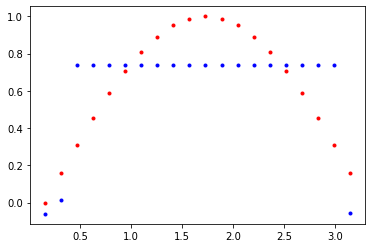

Loss:  0.06338723003864288


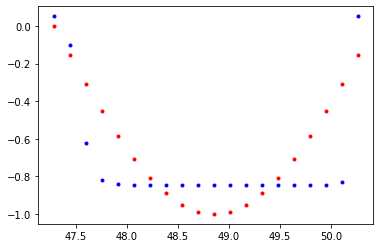

Loss:  0.06458842009305954


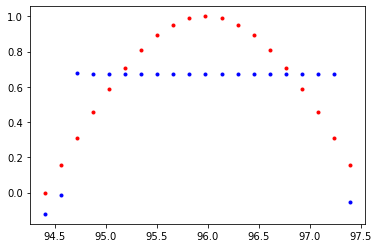

Loss:  0.06035419553518295


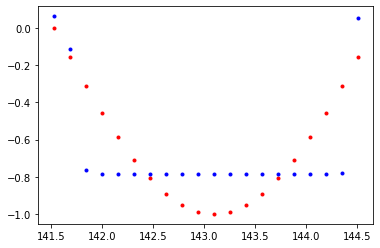

Loss:  0.06276511400938034


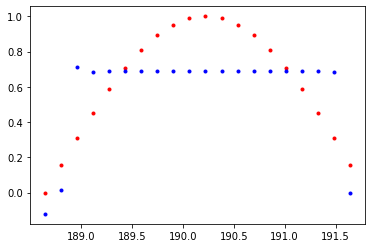

Loss:  0.07968529313802719


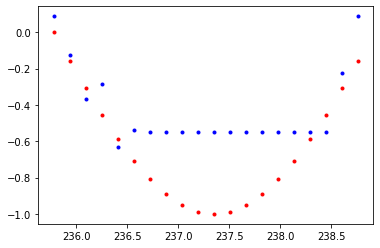

Loss:  0.06527398526668549


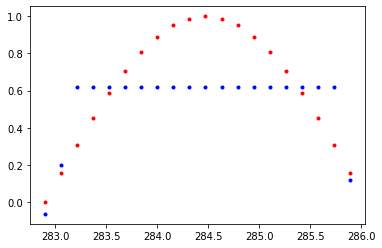

Loss:  0.053785115480422974


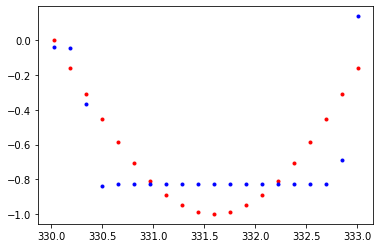

Loss:  0.055063214153051376


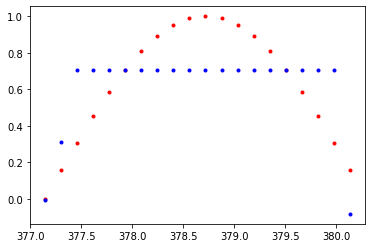

Loss:  0.05628085508942604


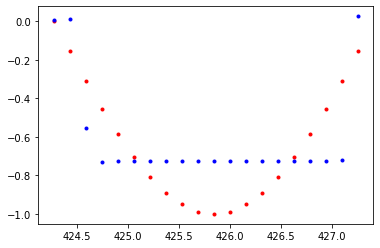

Loss:  0.05385132506489754


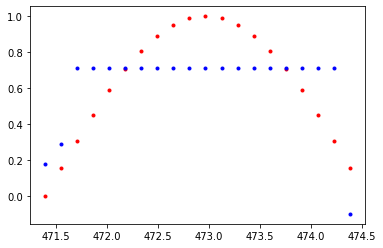

Loss:  0.055957674980163574


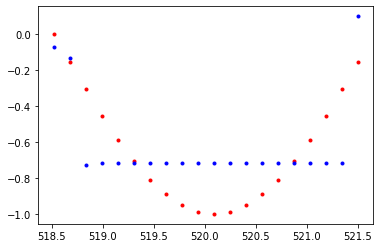

Loss:  0.05676111951470375


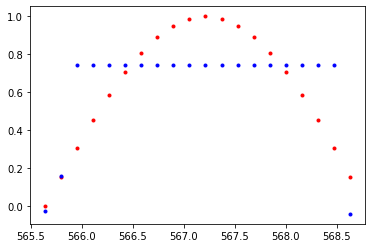

Loss:  0.05427480489015579


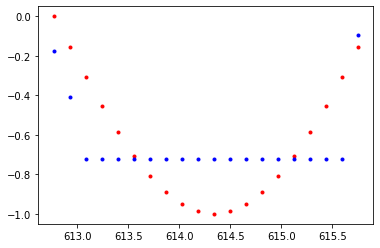

Loss:  0.054287757724523544


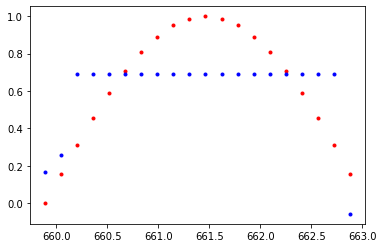

Loss:  0.05341188609600067


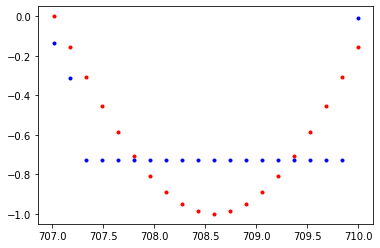

Loss:  0.05333269387483597


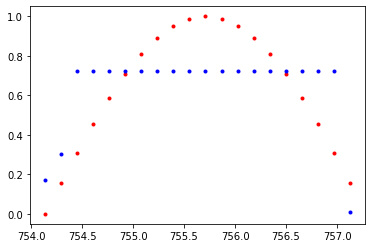

Loss:  0.05332352966070175


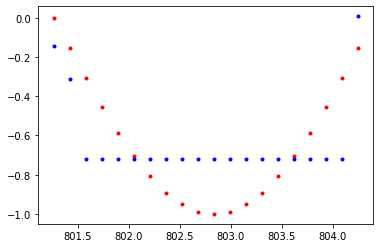

Loss:  0.05331460013985634


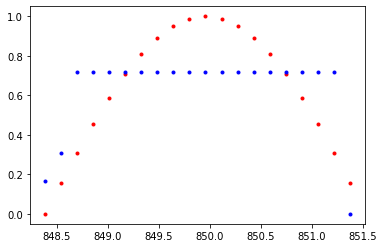

Loss:  0.05331184342503548


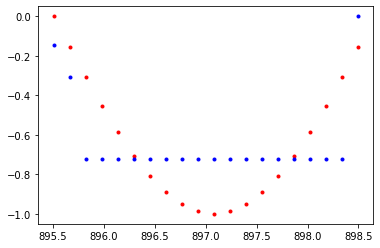

Loss:  0.05331216752529144


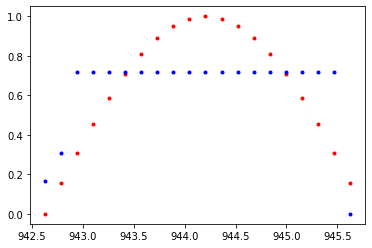

Loss:  0.05331149697303772


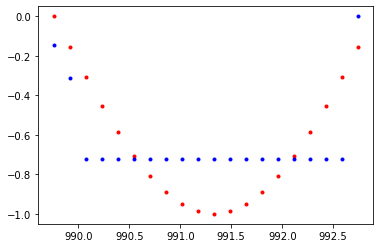

Loss:  0.053312987089157104


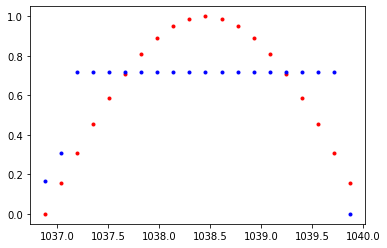

Loss:  0.053312141448259354


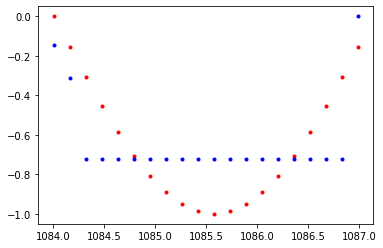

Loss:  0.053313687443733215


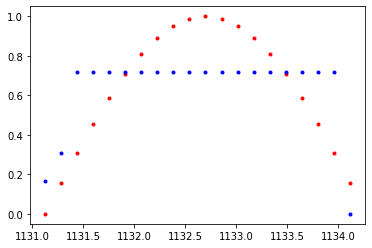

Loss:  0.053312744945287704


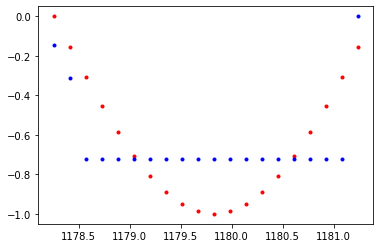

Loss:  0.05331449583172798


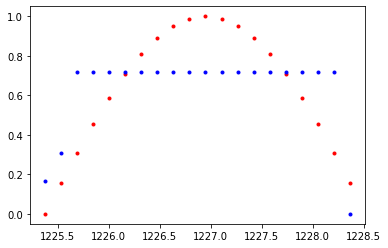

Loss:  0.05331341177225113


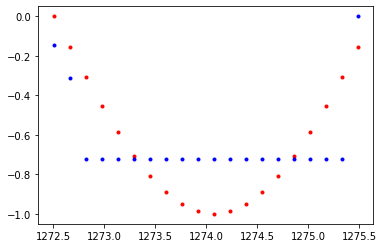

Loss:  0.05331538990139961


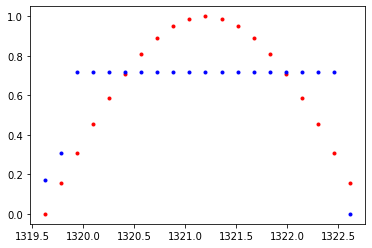

Loss:  0.053314171731472015


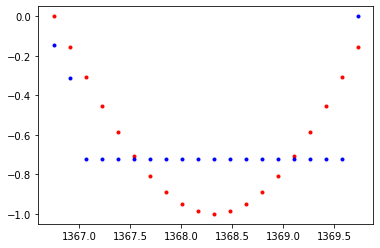

Loss:  0.053316377103328705


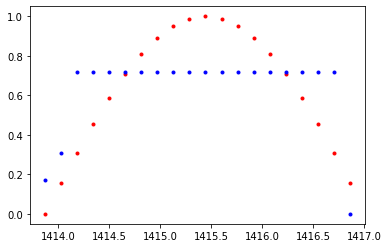

Loss:  0.053315017372369766


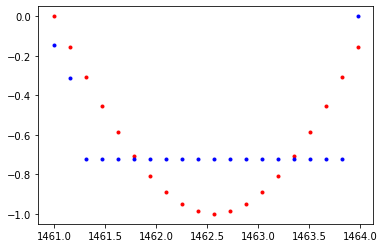

Loss:  0.05331738665699959


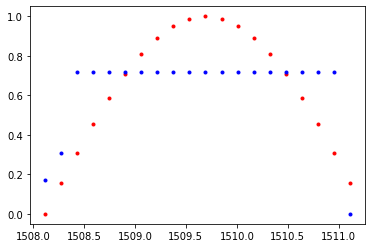

Loss:  0.053315918892621994


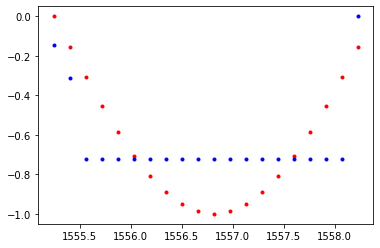

Loss:  0.05331830307841301


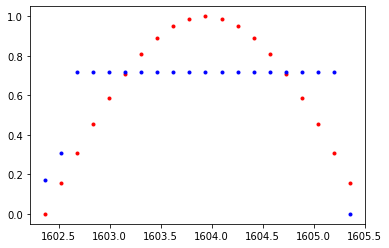

Loss:  0.05331677198410034


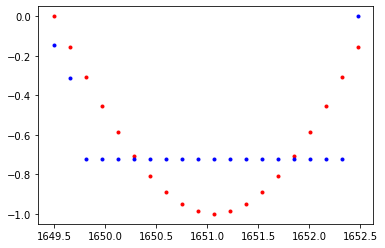

Loss:  0.05331898108124733


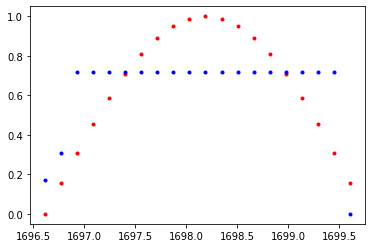

Loss:  0.053317487239837646


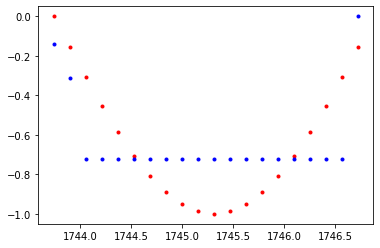

Loss:  0.05331927165389061


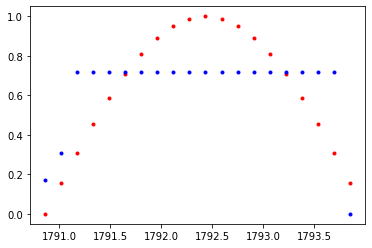

Loss:  0.05331794172525406


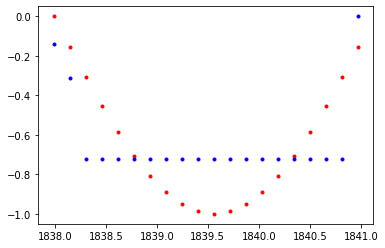

Loss:  0.05331919342279434


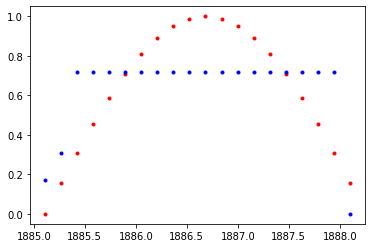

Loss:  0.05331805720925331


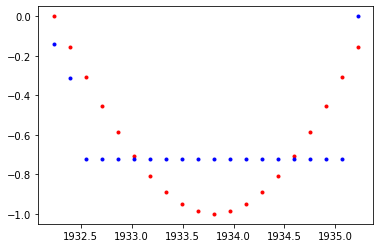

Loss:  0.05331876128911972


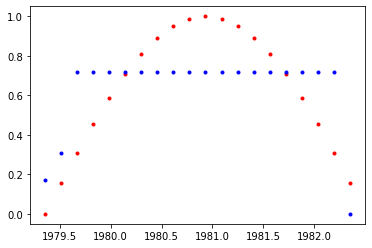

Loss:  0.0533178448677063


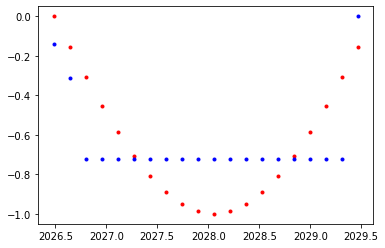

Loss:  0.05331810191273689


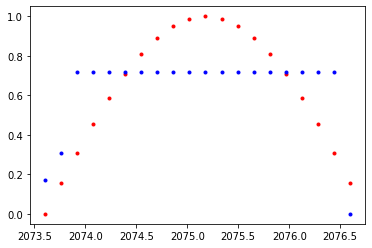

Loss:  0.053317394107580185


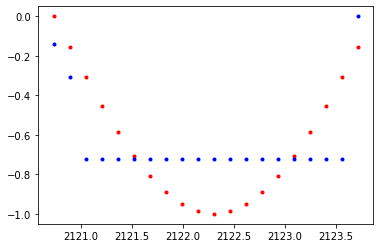

Loss:  0.053317345678806305


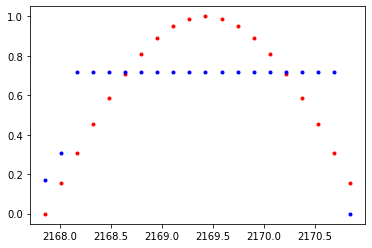

Loss:  0.05331679433584213


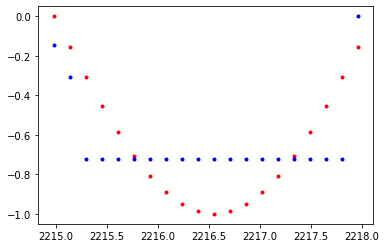

Loss:  0.05331655964255333


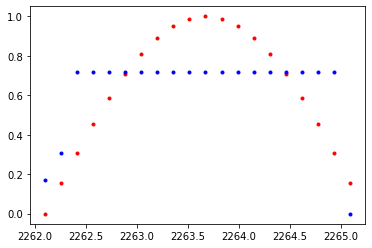

Loss:  0.0533161386847496


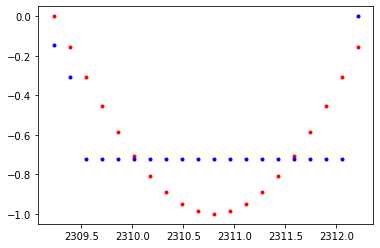

Loss:  0.05331582948565483


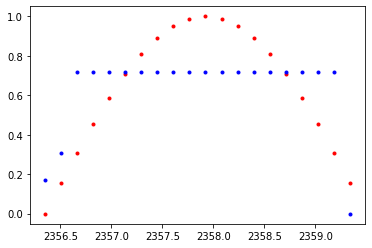

Loss:  0.053315479308366776


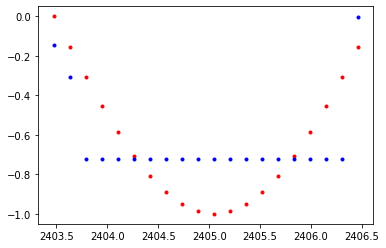

Loss:  0.05331513285636902


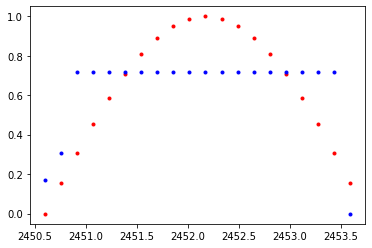

Loss:  0.053314853459596634


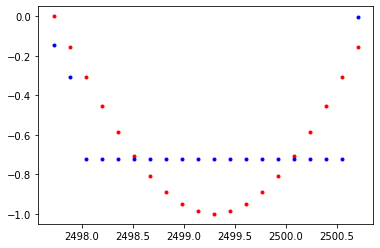

Loss:  0.05331451818346977


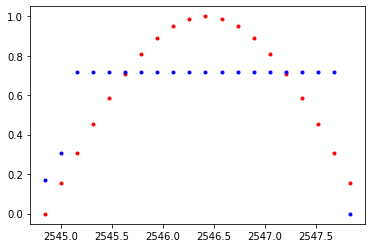

Loss:  0.05331427976489067


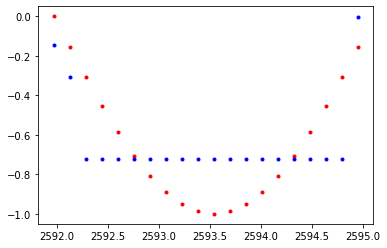

Loss:  0.053313981741666794


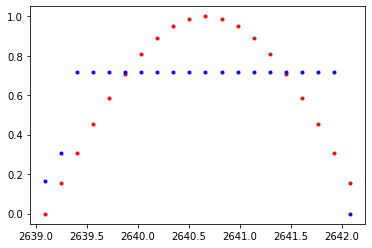

Loss:  0.05331374332308769


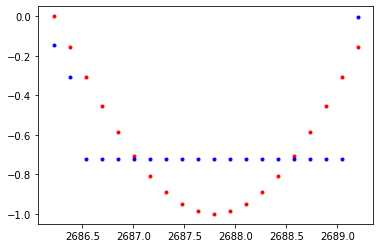

Loss:  0.0533134788274765


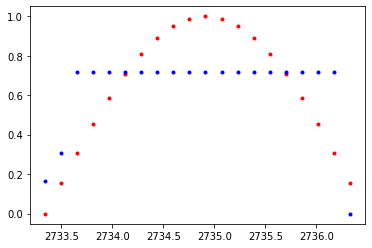

Loss:  0.05331327021121979


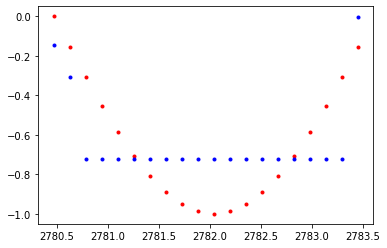

Loss:  0.053313061594963074


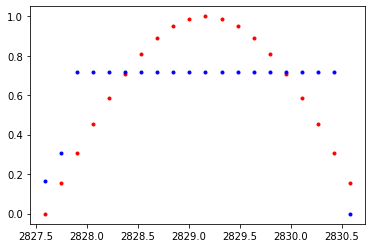

Loss:  0.053312841802835464


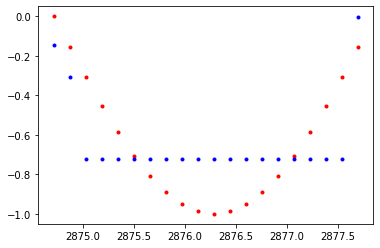

Loss:  0.05331267789006233


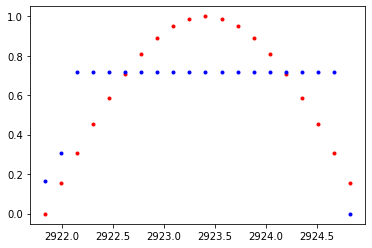

Loss:  0.05331244692206383


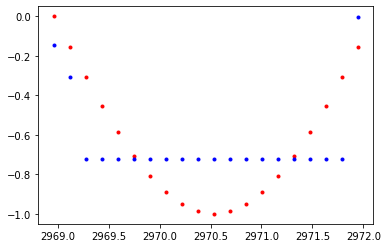

Loss:  0.05331234261393547


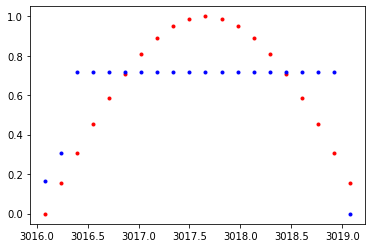

Loss:  0.05331210792064667


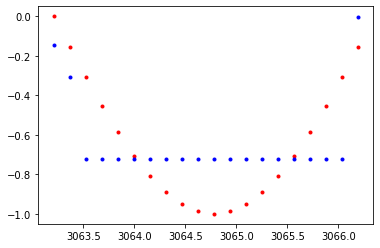

Loss:  0.0533120334148407


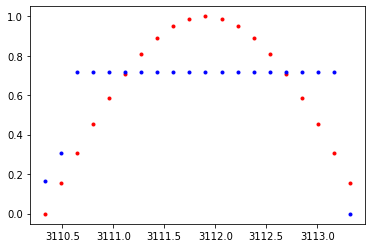

hidden dimension 26
Loss:  0.09640995413064957


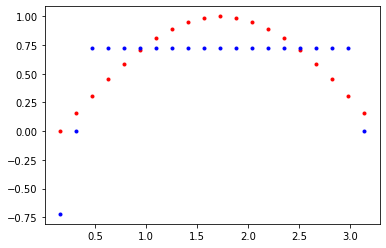

Loss:  0.05476381629705429


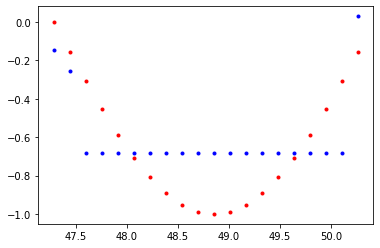

Loss:  0.05340760946273804


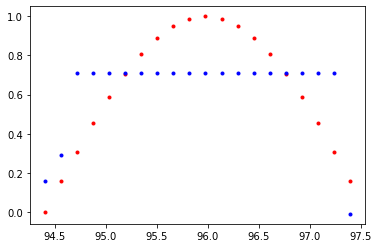

Loss:  0.05332715064287186


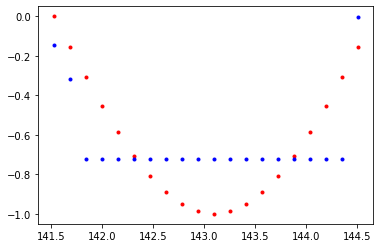

Loss:  0.05331343784928322


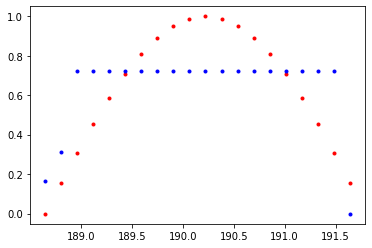

Loss:  0.053310614079236984


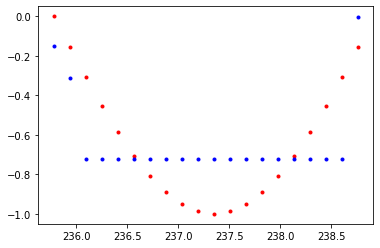

Loss:  0.053311239928007126


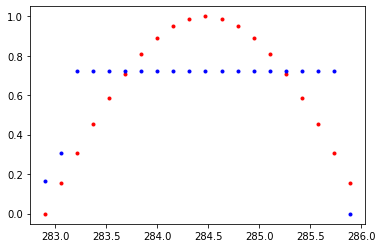

Loss:  0.053311023861169815


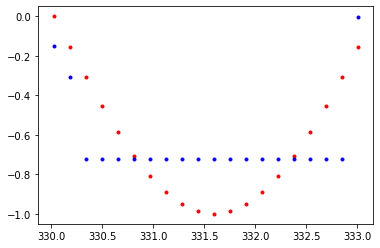

Loss:  0.0533110611140728


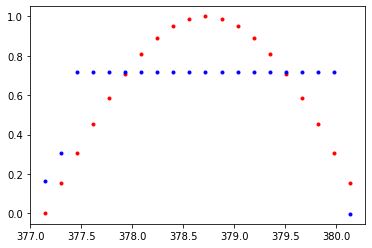

Loss:  0.05331069231033325


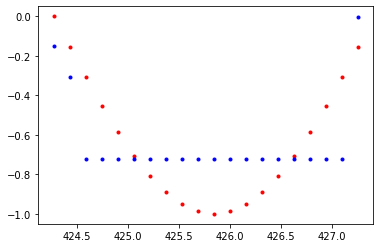

Loss:  0.05331076681613922


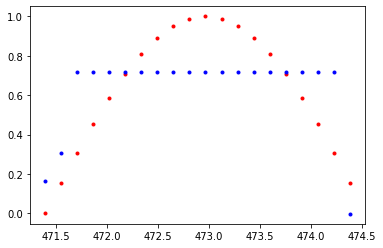

Loss:  0.053310491144657135


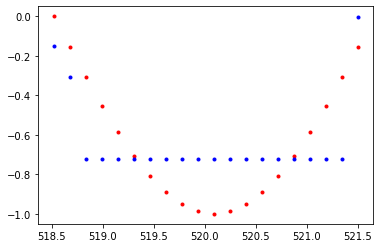

Loss:  0.05331059917807579


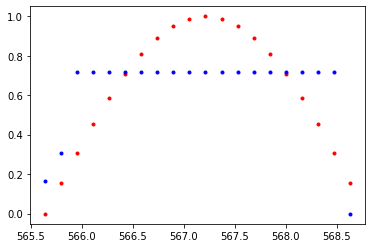

Loss:  0.053310323506593704


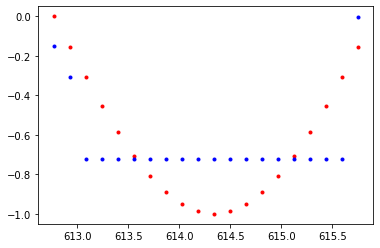

Loss:  0.05331045016646385


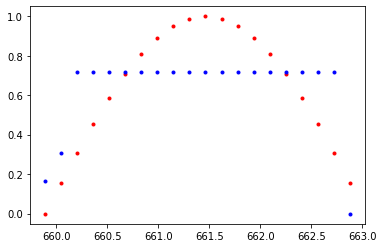

Loss:  0.05331015959382057


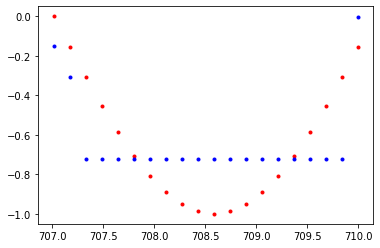

Loss:  0.05331030115485191


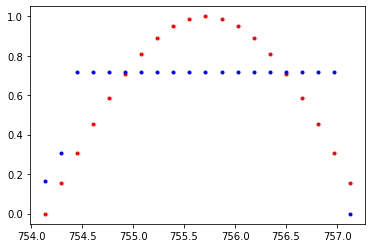

Loss:  0.05331002175807953


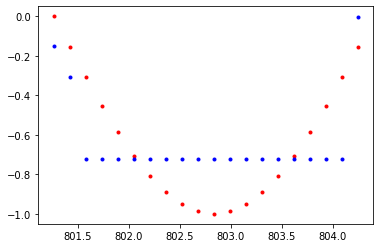

Loss:  0.053310178220272064


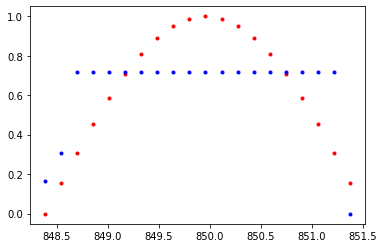

Loss:  0.053309887647628784


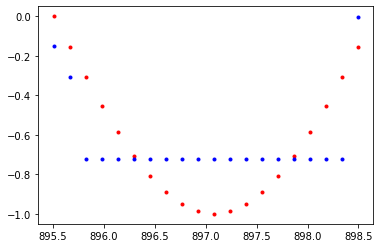

Loss:  0.053310051560401917


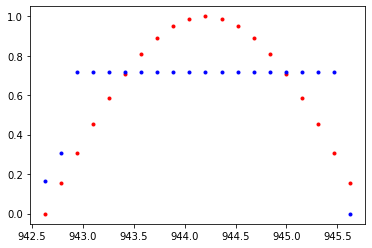

Loss:  0.053309760987758636


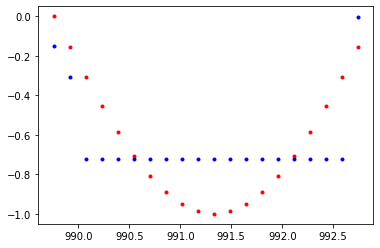

Loss:  0.05330993980169296


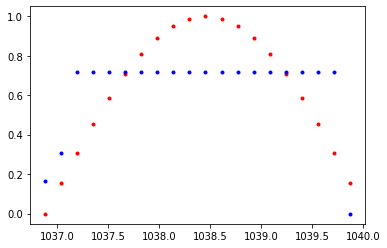

Loss:  0.053309645503759384


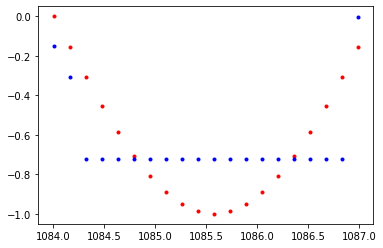

Loss:  0.05330983176827431


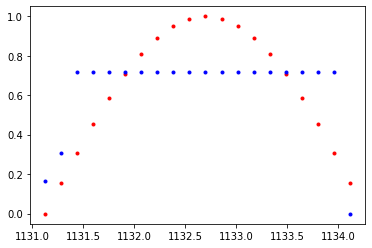

Loss:  0.05330953374505043


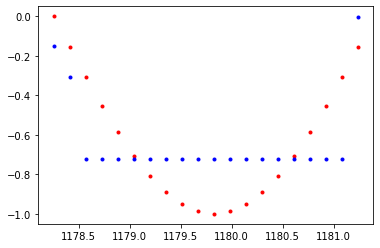

Loss:  0.05330974608659744


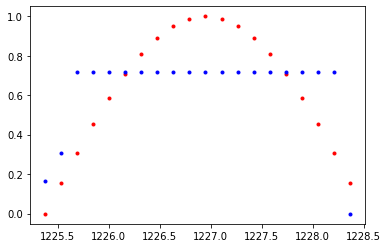

Loss:  0.05330944061279297


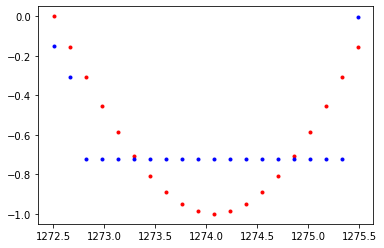

Loss:  0.05330966040492058


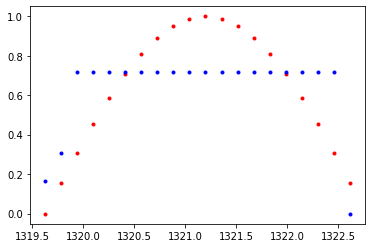

Loss:  0.05330934375524521


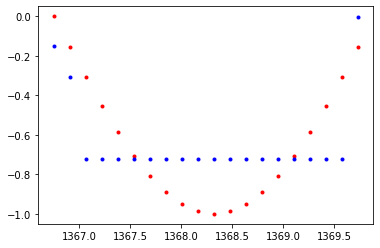

Loss:  0.053309570997953415


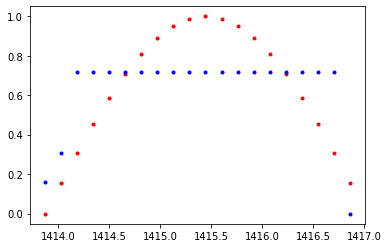

Loss:  0.05330925062298775


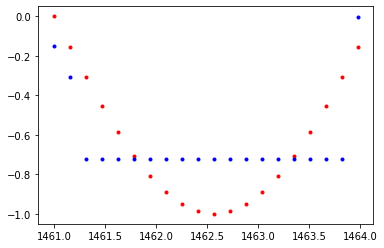

Loss:  0.05330949276685715


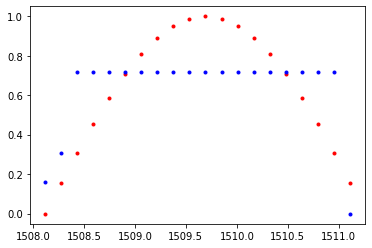

Loss:  0.05330916866660118


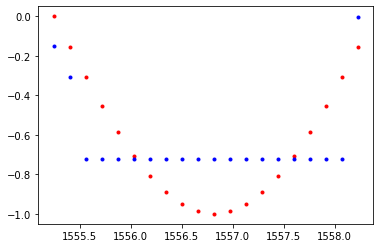

Loss:  0.053309421986341476


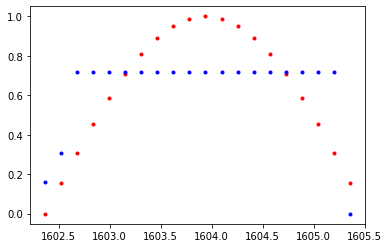

Loss:  0.05330909043550491


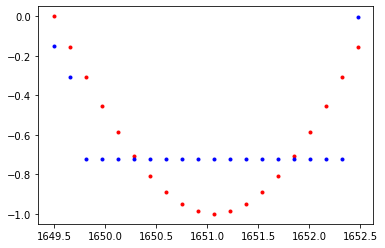

Loss:  0.053309351205825806


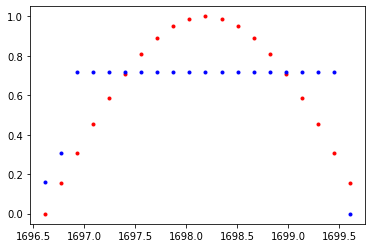

Loss:  0.053309015929698944


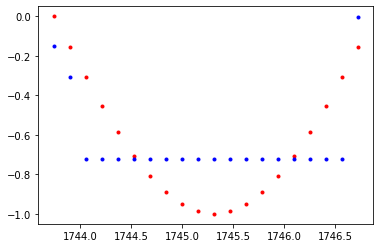

Loss:  0.053309276700019836


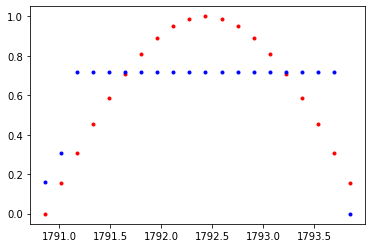

Loss:  0.05330894887447357


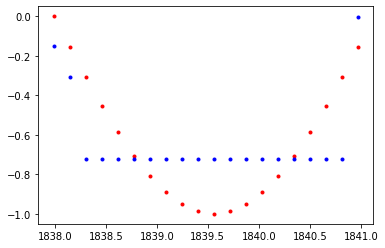

Loss:  0.05330921709537506


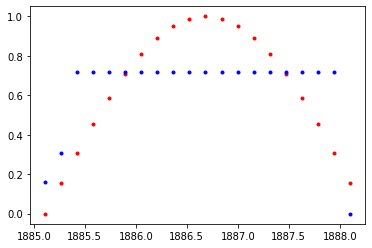

Loss:  0.0533088818192482


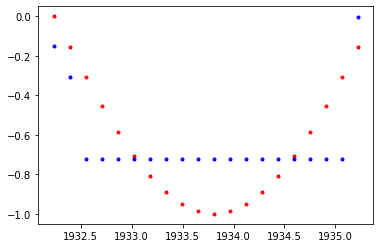

Loss:  0.053309161216020584


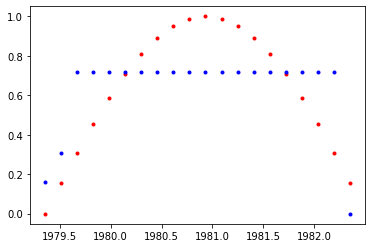

Loss:  0.053308818489313126


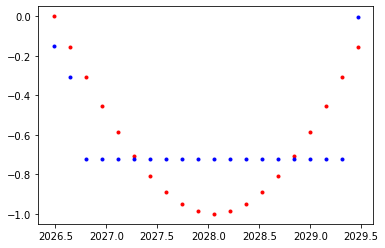

Loss:  0.05330910161137581


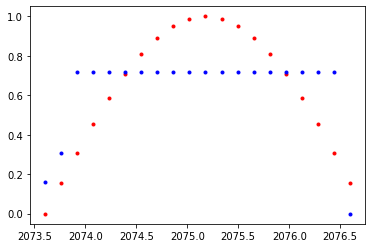

Loss:  0.05330875143408775


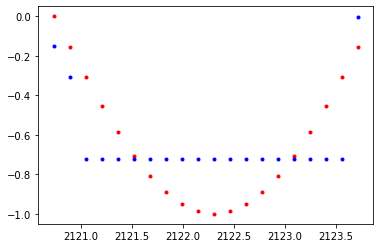

Loss:  0.05330905318260193


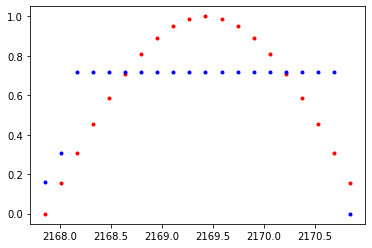

Loss:  0.053308695554733276


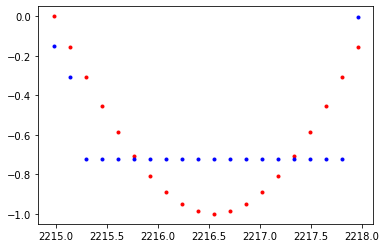

Loss:  0.05330900847911835


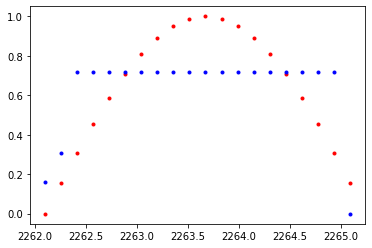

Loss:  0.0533086434006691


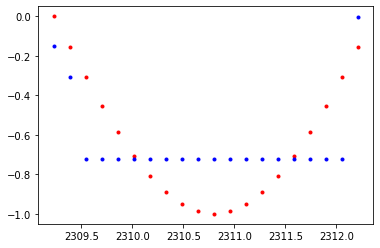

Loss:  0.05330895259976387


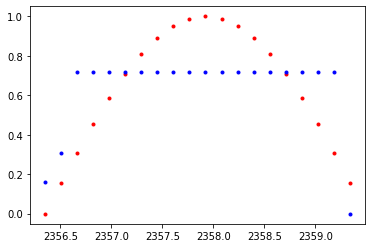

Loss:  0.05330858379602432


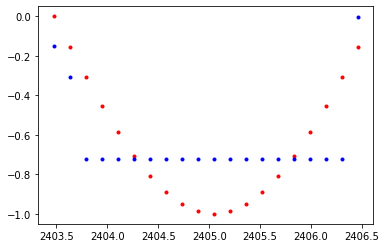

Loss:  0.05330890789628029


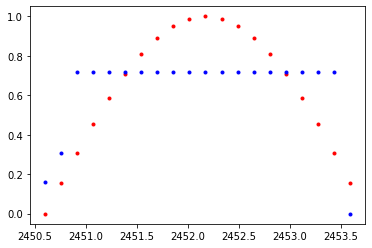

Loss:  0.05330854281783104


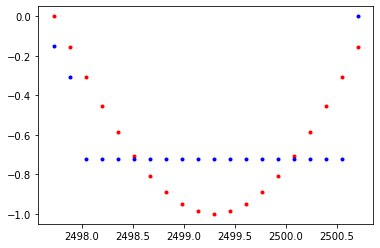

Loss:  0.05330886319279671


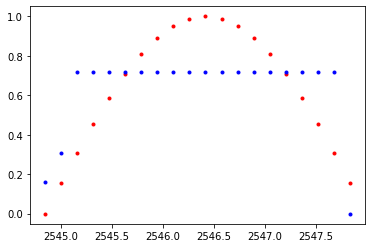

Loss:  0.05330849066376686


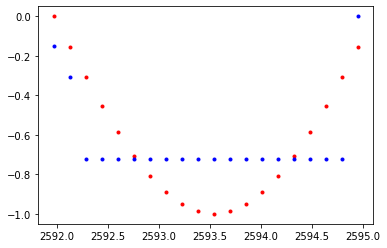

Loss:  0.053308822214603424


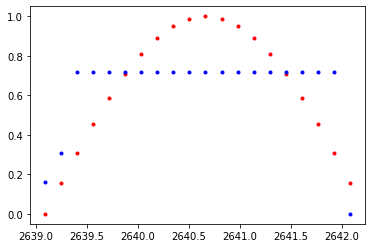

Loss:  0.05330844596028328


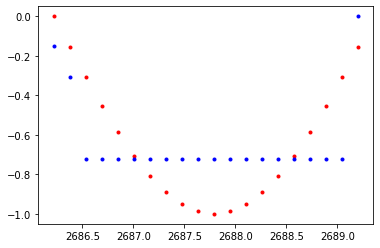

Loss:  0.05330878123641014


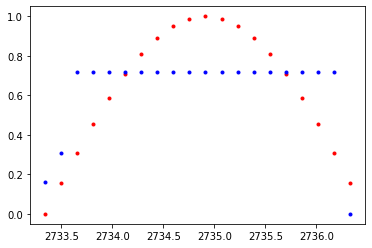

Loss:  0.0533084012567997


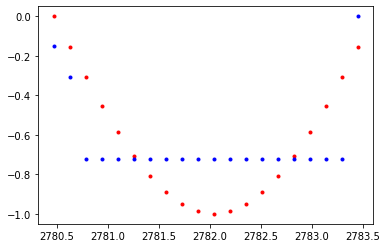

Loss:  0.05330881476402283


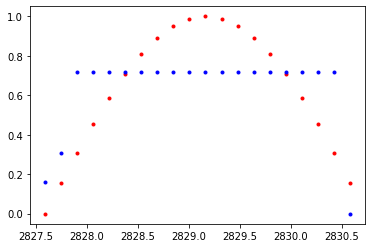

Loss:  0.05330847203731537


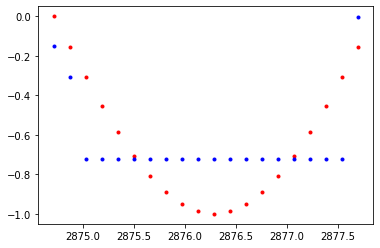

Loss:  0.053368378430604935


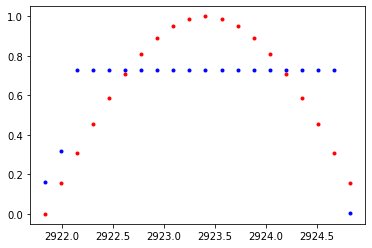

Loss:  0.06351373344659805


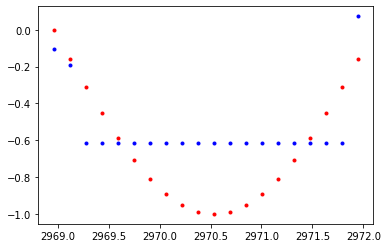

Loss:  0.05355732887983322


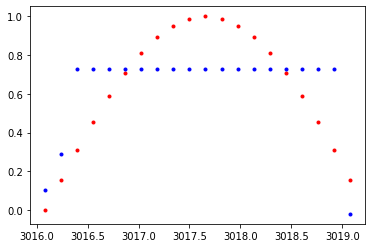

Loss:  0.0587923489511013


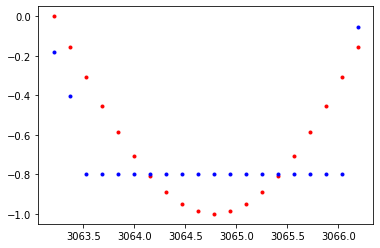

Loss:  0.05344020947813988


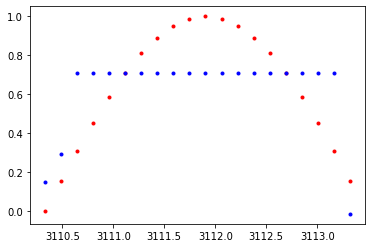

hidden size to loss {1: 0.00015293934848159552, 6: 0.00028801392181776464, 11: 0.11991497874259949, 16: 0.05405664071440697, 21: 0.05331185832619667, 26: 0.053486187011003494}


In [17]:
# train the rnn and monitor results
n_steps = 1000
print_every = 15

hiddenDimToLoss = {}

for hid in range(1,31,5):
    hidden_dim = hid
    print(f"hidden dimension {hidden_dim}")
    trained_rnn, loss = train(rnn, n_steps, print_every, True)
    hiddenDimToLoss[hidden_dim] = loss

print(f"hidden size to loss {hiddenDimToLoss}")

In [19]:
print(f"hidden size to loss {hiddenDimToLoss}")

hidden size to loss {1: 0.00015293934848159552, 6: 0.00028801392181776464, 11: 0.11991497874259949, 16: 0.05405664071440697, 21: 0.05331185832619667, 26: 0.053486187011003494}


# Observations

Less number of hidden states (1) gives better results than higher number (32) !!!
Why?